In [80]:
# !pip install scanpy
# !pip install anndata
# !pip install yellowbrick

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import scanpy.plotting as sc_pl
from numpy.linalg import eigh
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer
from sklearn import mixture   
import itertools
import matplotlib as mpl
import matplotlib.colors
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer



import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


%matplotlib inline

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

In [82]:
# from google.colab import drive
# drive.mount('/content/drive')

# data1 = pd.read_csv('/content/drive/MyDrive/Classroom/Alvanakis_Apostolou_Spyridon_7115152200020_3Assignment/dataset1.csv')
# data2 = pd.read_csv('/content/drive/MyDrive/Classroom/Alvanakis_Apostolou_Spyridon_7115152200020_3Assignment/dataset2.csv')
# data3 = pd.read_csv('/content/drive/MyDrive/Classroom/Alvanakis_Apostolou_Spyridon_7115152200020_3Assignment/dataset3.csv')
# data4 = pd.read_csv('/content/drive/MyDrive/Classroom/Alvanakis_Apostolou_Spyridon_7115152200020_3Assignment/dataset4.csv')
# data5 = pd.read_csv('/content/drive/MyDrive/Classroom/Alvanakis_Apostolou_Spyridon_7115152200020_3Assignment/dataset5.csv')

In [83]:
data1 = pd.read_csv('dataset1.csv')
data2 = pd.read_csv('dataset2.csv')
data3 = pd.read_csv('dataset3.csv')
data4 = pd.read_csv('dataset4.csv')
data5 = pd.read_csv('dataset5.csv')

In [84]:
data1 = data1.set_index('Unnamed: 0')
data2 = data2.set_index('Unnamed: 0')
data3 = data3.set_index('Unnamed: 0')
data4 = data4.set_index('Unnamed: 0')
data5 = data5.set_index('Unnamed: 0')

In [85]:
# Choose one of these dataframes 
data_2_use = data1

# Dimentionality reduction#

## Preprocess ##

In [86]:
# Initiate the adata 
counts = csr_matrix(np.random.poisson(1, size=(data_2_use.shape[0], data_2_use.shape[1])), dtype=np.float32)
adata = ad.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 200 × 200

In [87]:
# Set observation and variable names
adata.obs_names = data_2_use.index
adata.var_names = data_2_use.columns

In [88]:
# Set layers for the different dataframes and the values
adata.X = np.array(data_2_use)
adata

AnnData object with n_obs × n_vars = 200 × 200

### Quality control ###





In [89]:
# Copy the initial adata and calculate basic metrics
adata_wQC = adata.copy()
sc.pp.calculate_qc_metrics(adata_wQC, percent_top = None, log1p = False, inplace = True)

In [90]:
adata_wQC

AnnData object with n_obs × n_vars = 200 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [91]:
# Drop the duplicate columns and normalize
adata_wQC.var_names_make_unique()

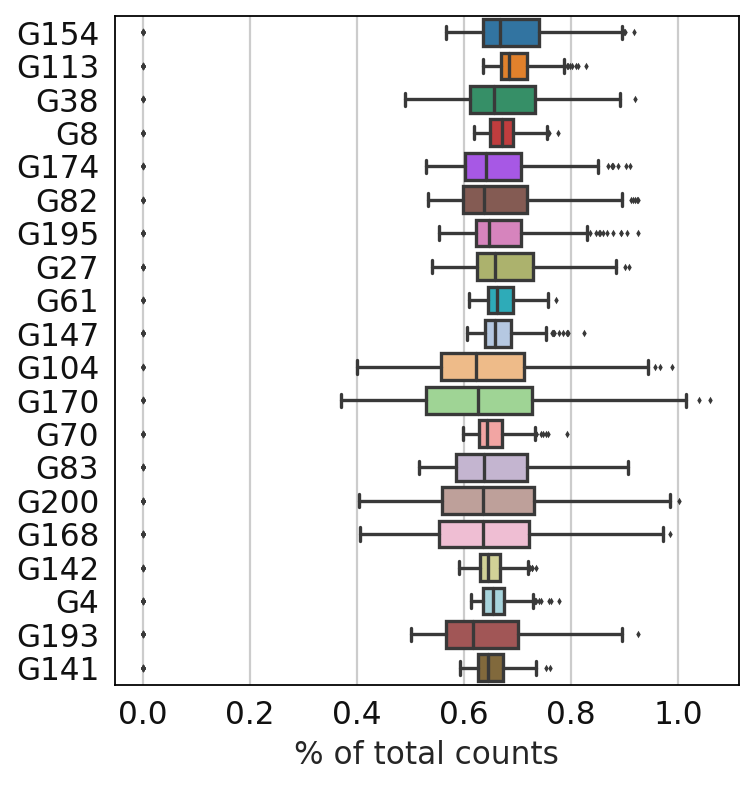

In [92]:
# Check the top genes just for fun
sc.pl.highest_expr_genes(adata_wQC, n_top=20 )

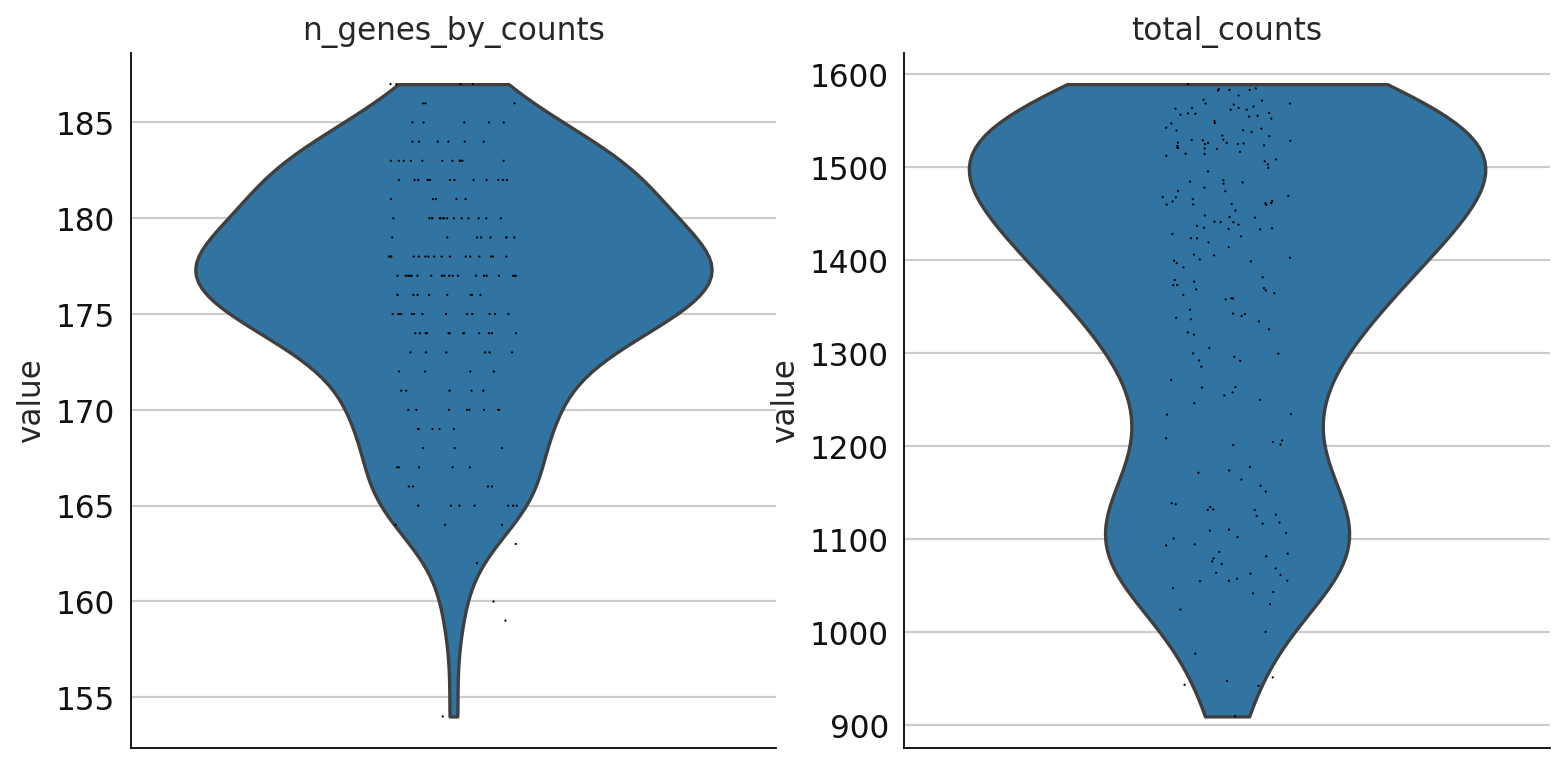

In [93]:
# Plot a violin plot with QC metrics 
sc.pl.violin(adata_wQC, ['n_genes_by_counts', 'total_counts'], multi_panel = True)

In [94]:
sc.pp.filter_genes(adata_wQC, min_cells=20)
adata_wQC.X.shape

(200, 200)

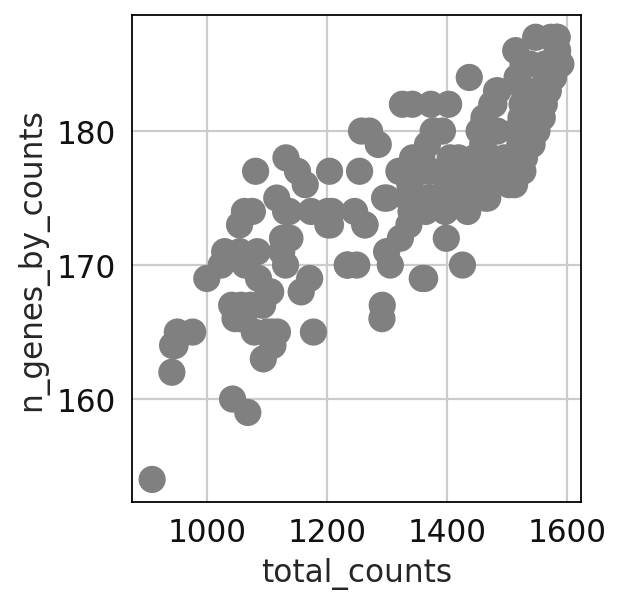

In [95]:
# Scatterplot to explore the genes per cell. If there were a specific amount on a reaserch, or less, of genes in some cells we could filter those cells.
sc.pl.scatter(adata_wQC, y = 'n_genes_by_counts', x = 'total_counts') 

--------------------------------------------------------------------------

**CHOOSE QUALITY CONTROL METHOD**

--------------------------------------------------------------------------


In [96]:
# Remove the distance cells
adata_wQC = adata_wQC[adata_wQC.obs.n_genes_by_counts > 160, :] ### 1st and 3rd dataset
# adata_wQC = adata_wQC[adata_wQC.obs.n_genes_by_counts > 167, :] ### 2nd dataset 
# adata_wQC = adata_wQC[adata_wQC.obs.n_genes_by_counts > 166, :]  ### 4th dataset 
# adata_wQC = adata_wQC[adata_wQC.obs.n_genes_by_counts > 165, :]    ###   5th dataset
print(adata_wQC)

View of AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'


#### Normalization ####

In [97]:
# Total-count normalize the data matrix X to the median reads per cell, so that counts become comparable among cells.
scales_counts = sc.pp.normalize_total(adata_wQC, target_sum=None, inplace=False)
# log1p transform
adata_wQC.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata_wQC

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'log1p_norm'

In [98]:
print(adata_wQC)

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'log1p_norm'


### Highly Variable Genes (HVG) ###

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

However, the recommended number of HVGs is typically between 1,000 and 5,000.

Considering the dataset consists of only 200 genes, it seems not necessary to select HVGs since your gene count is already at a low level. Applying a high variance feature selection may not bring additional value and could even distort the results due to over-filtering in this case.

In [99]:
# Gene expression for the cells
sc.pp.highly_variable_genes(adata_wQC, flavor='seurat',max_mean = 10, min_mean = 0.0125)
adata_wQC

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'log1p_norm'

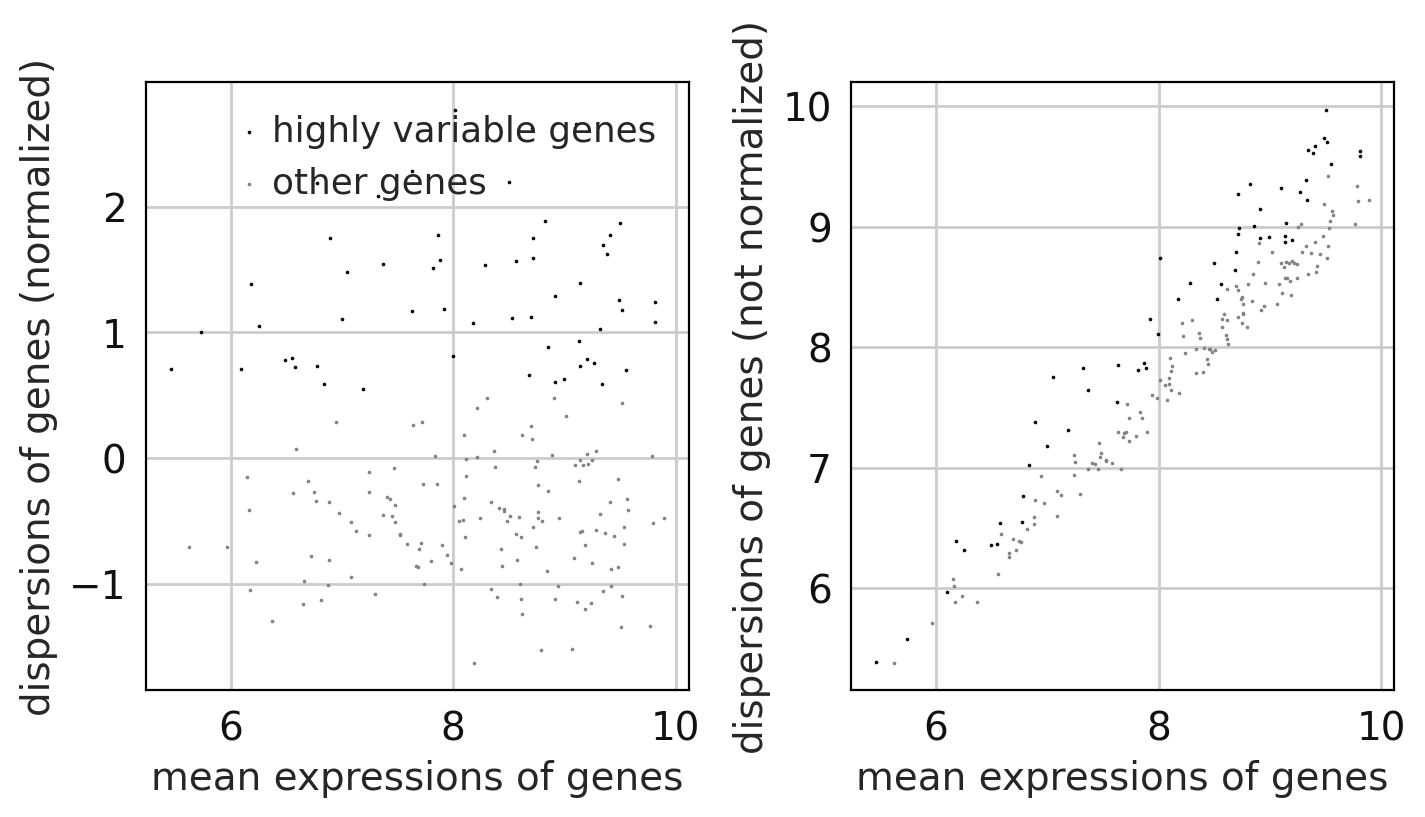

In [100]:
sc.set_figure_params(dpi=100) 
sc.pl.highly_variable_genes(adata_wQC)  

In [101]:
# The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA.
# In that case, the step actually do the filtering below is unnecessary, too.

# adata_wQC = adata_wQC[:, adata_wQC.var.highly_variable]

# Variables (genes) that do not display any variation (are constant across all observations) are retained and (for zero_center==True) set to 0 during this operation. 
sc.pp.scale(adata_wQC, max_value=2)


## PCA ##


In [102]:
adata_wQC.X = adata_wQC.layers['log1p_norm']
adata_pca = adata_wQC.copy()
print(adata_wQC)

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    layers: 'log1p_norm'


In [103]:
# Choose the smallest feature
n_numb = min(adata_wQC.var_names.shape[0], adata_wQC.obs.shape[0])
n_numb

197

In [104]:
sc.tl.pca(adata_pca, svd_solver='arpack' , n_comps = n_numb-1, use_highly_variable=False) # n_comps = n_numb-1 is the maximum number of components sc.tl.pca can take
print(adata_pca)

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'log1p_norm'


Ideally, we aim for a cumulative variance of around 95% in PCA, as this enables us to retain most of the information and meaningful eigenvalues while reducing the dimensionality.

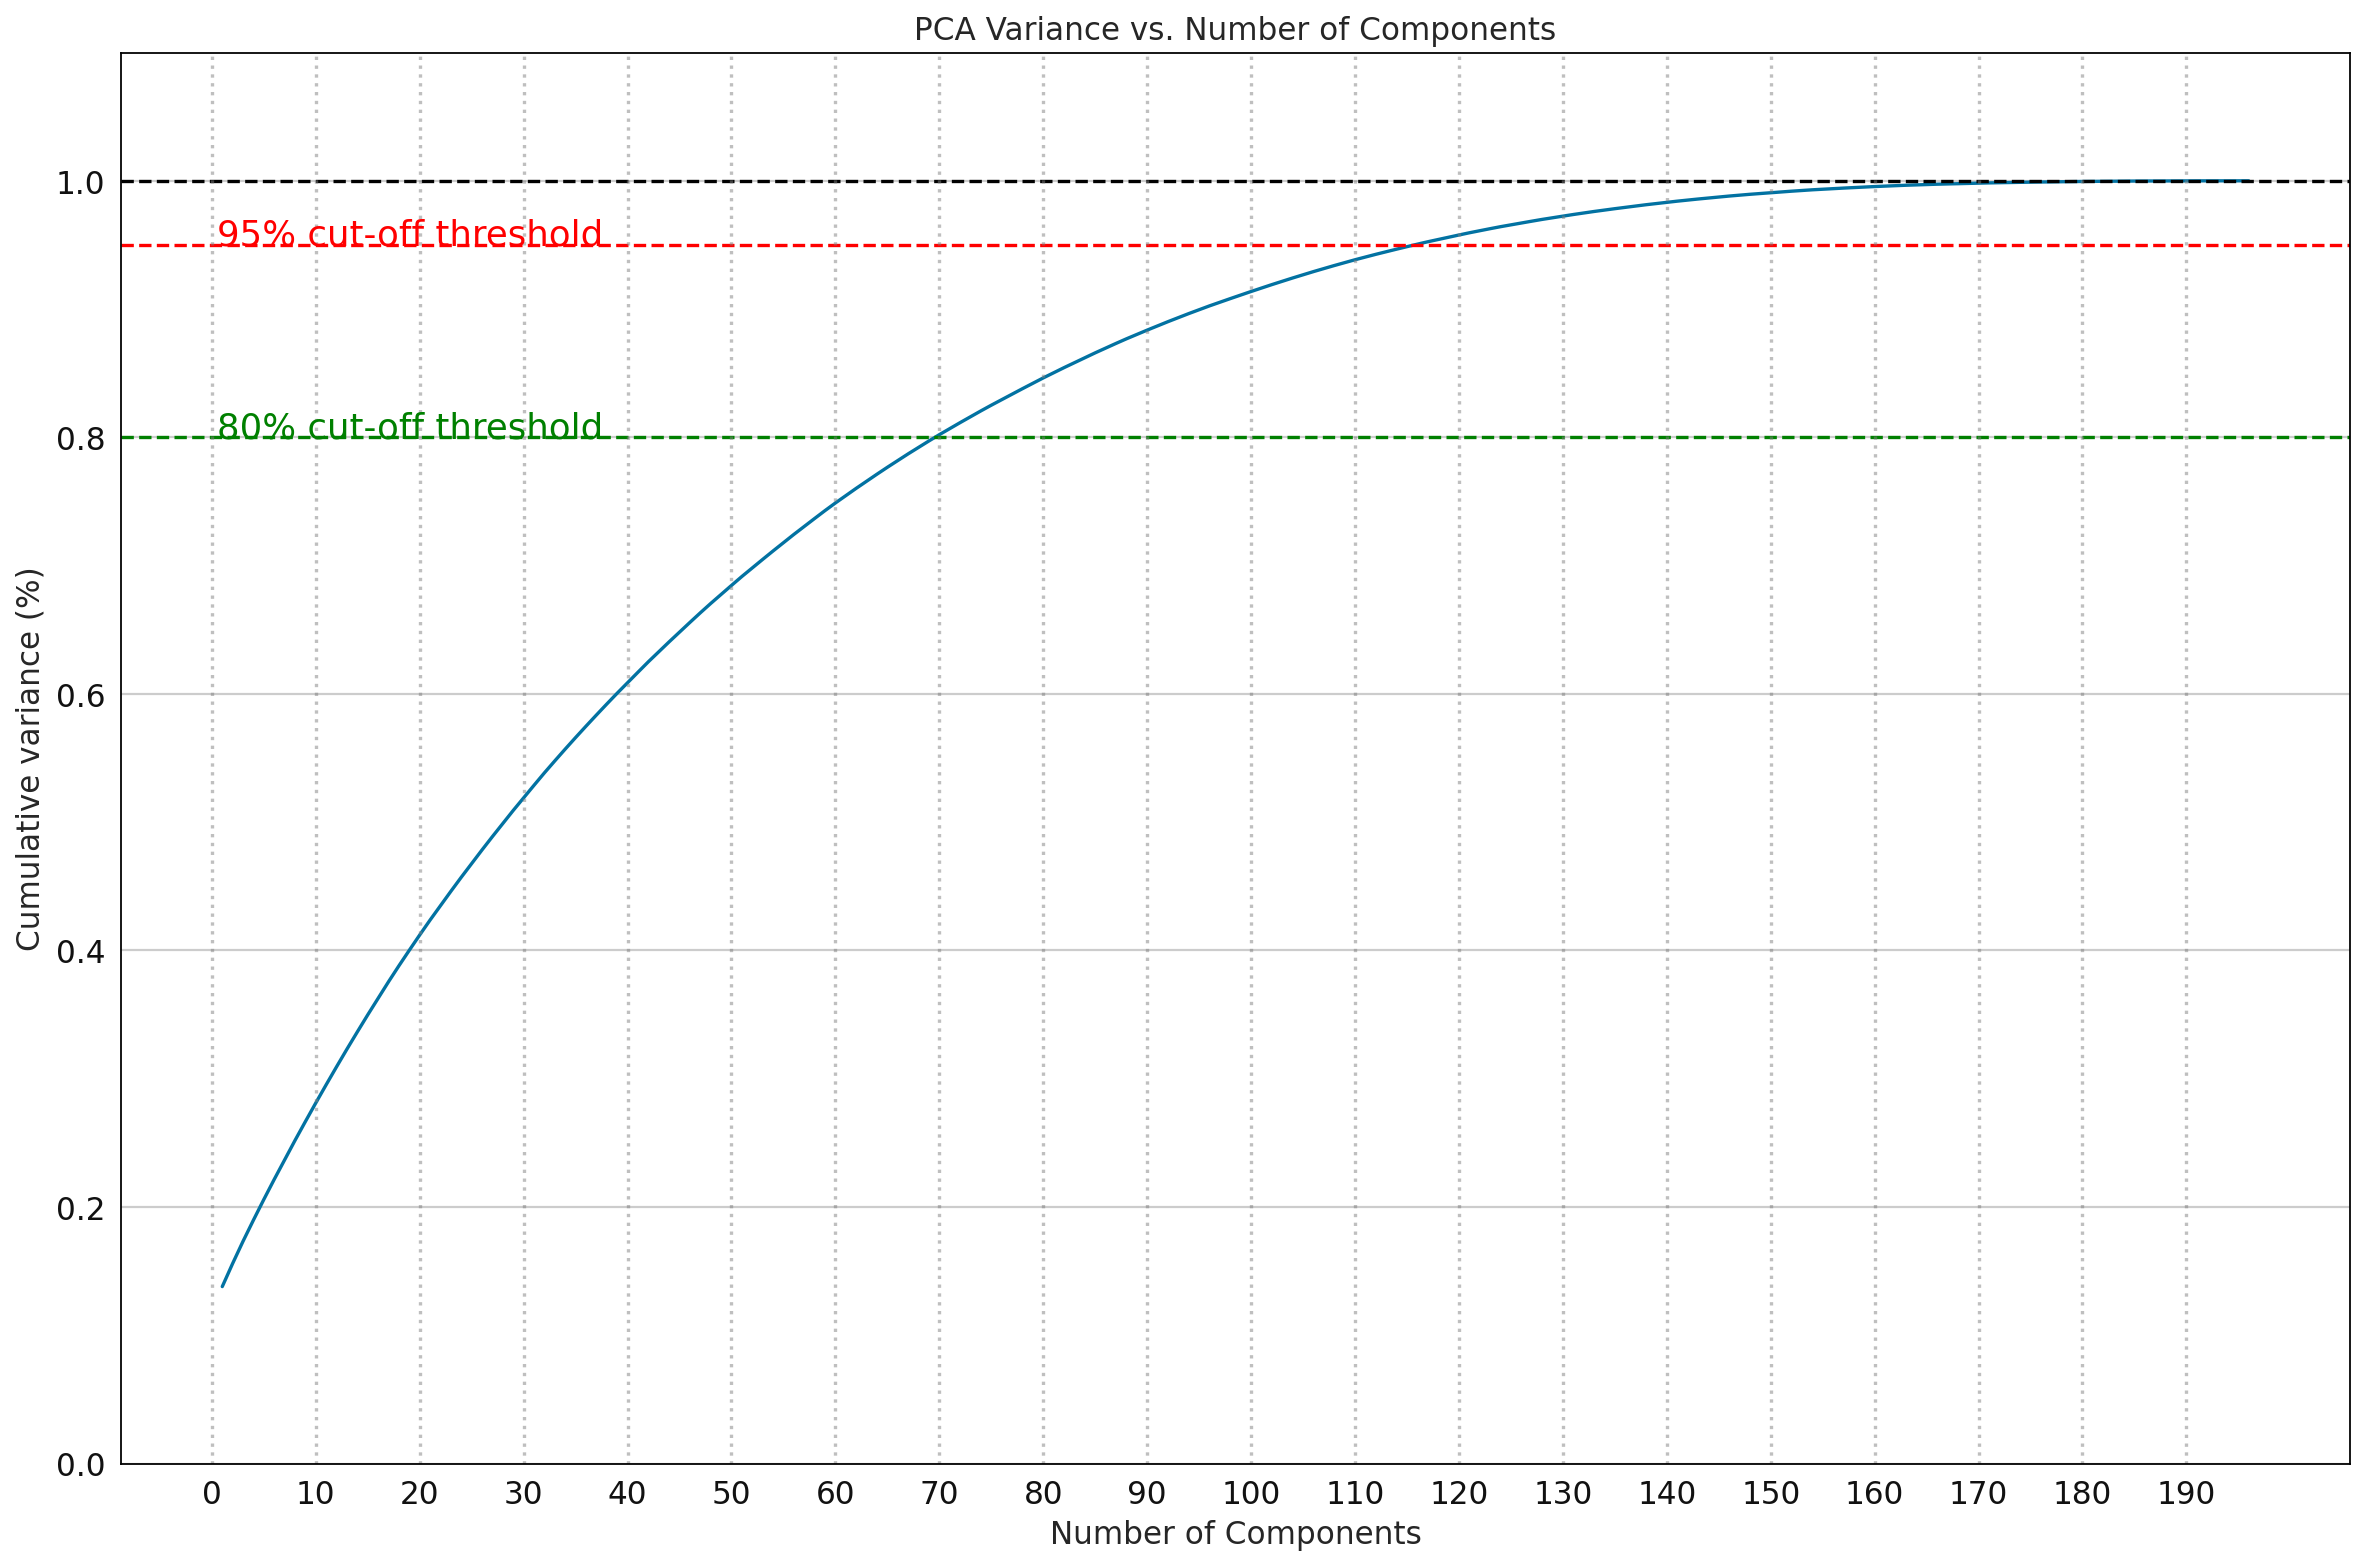

In [105]:
y = np.cumsum(adata_pca.uns['pca']['variance_ratio'])
x = range(1,y.shape[0]+1)

plt.figure(figsize=(15, 10), dpi=80)
plt.plot(x, y, marker=',', linestyle='-', color='b')
plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, adata_pca.uns['pca']['variance_ratio'].shape[0]+1, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('PCA Variance vs. Number of Components')

plt.axhline(y=0.95, color='red', linestyle='--')
plt.text(0.5, 0.95, '95% cut-off threshold', color='red', fontsize=16)
plt.axhline(y=0.80, color='green', linestyle='--')
plt.text(0.5, 0.80, '80% cut-off threshold', color='green', fontsize=16)
plt.axhline(y=1, color='black', linestyle='--')

for x in np.arange(0, adata_pca.uns['pca']['variance_ratio'].shape[0]+1, step=10):
    plt.axvline(x=x, color='gray', linestyle=':', alpha=0.5)

plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [106]:
# Store the number of components with over 95% cumulative variance
n_components_95 = np.where(y >= 0.95)[0][0] + 1
n_components_80 = np.where(y >= 0.8)[0][0] + 1
print(n_components_95, n_components_80)

116 70


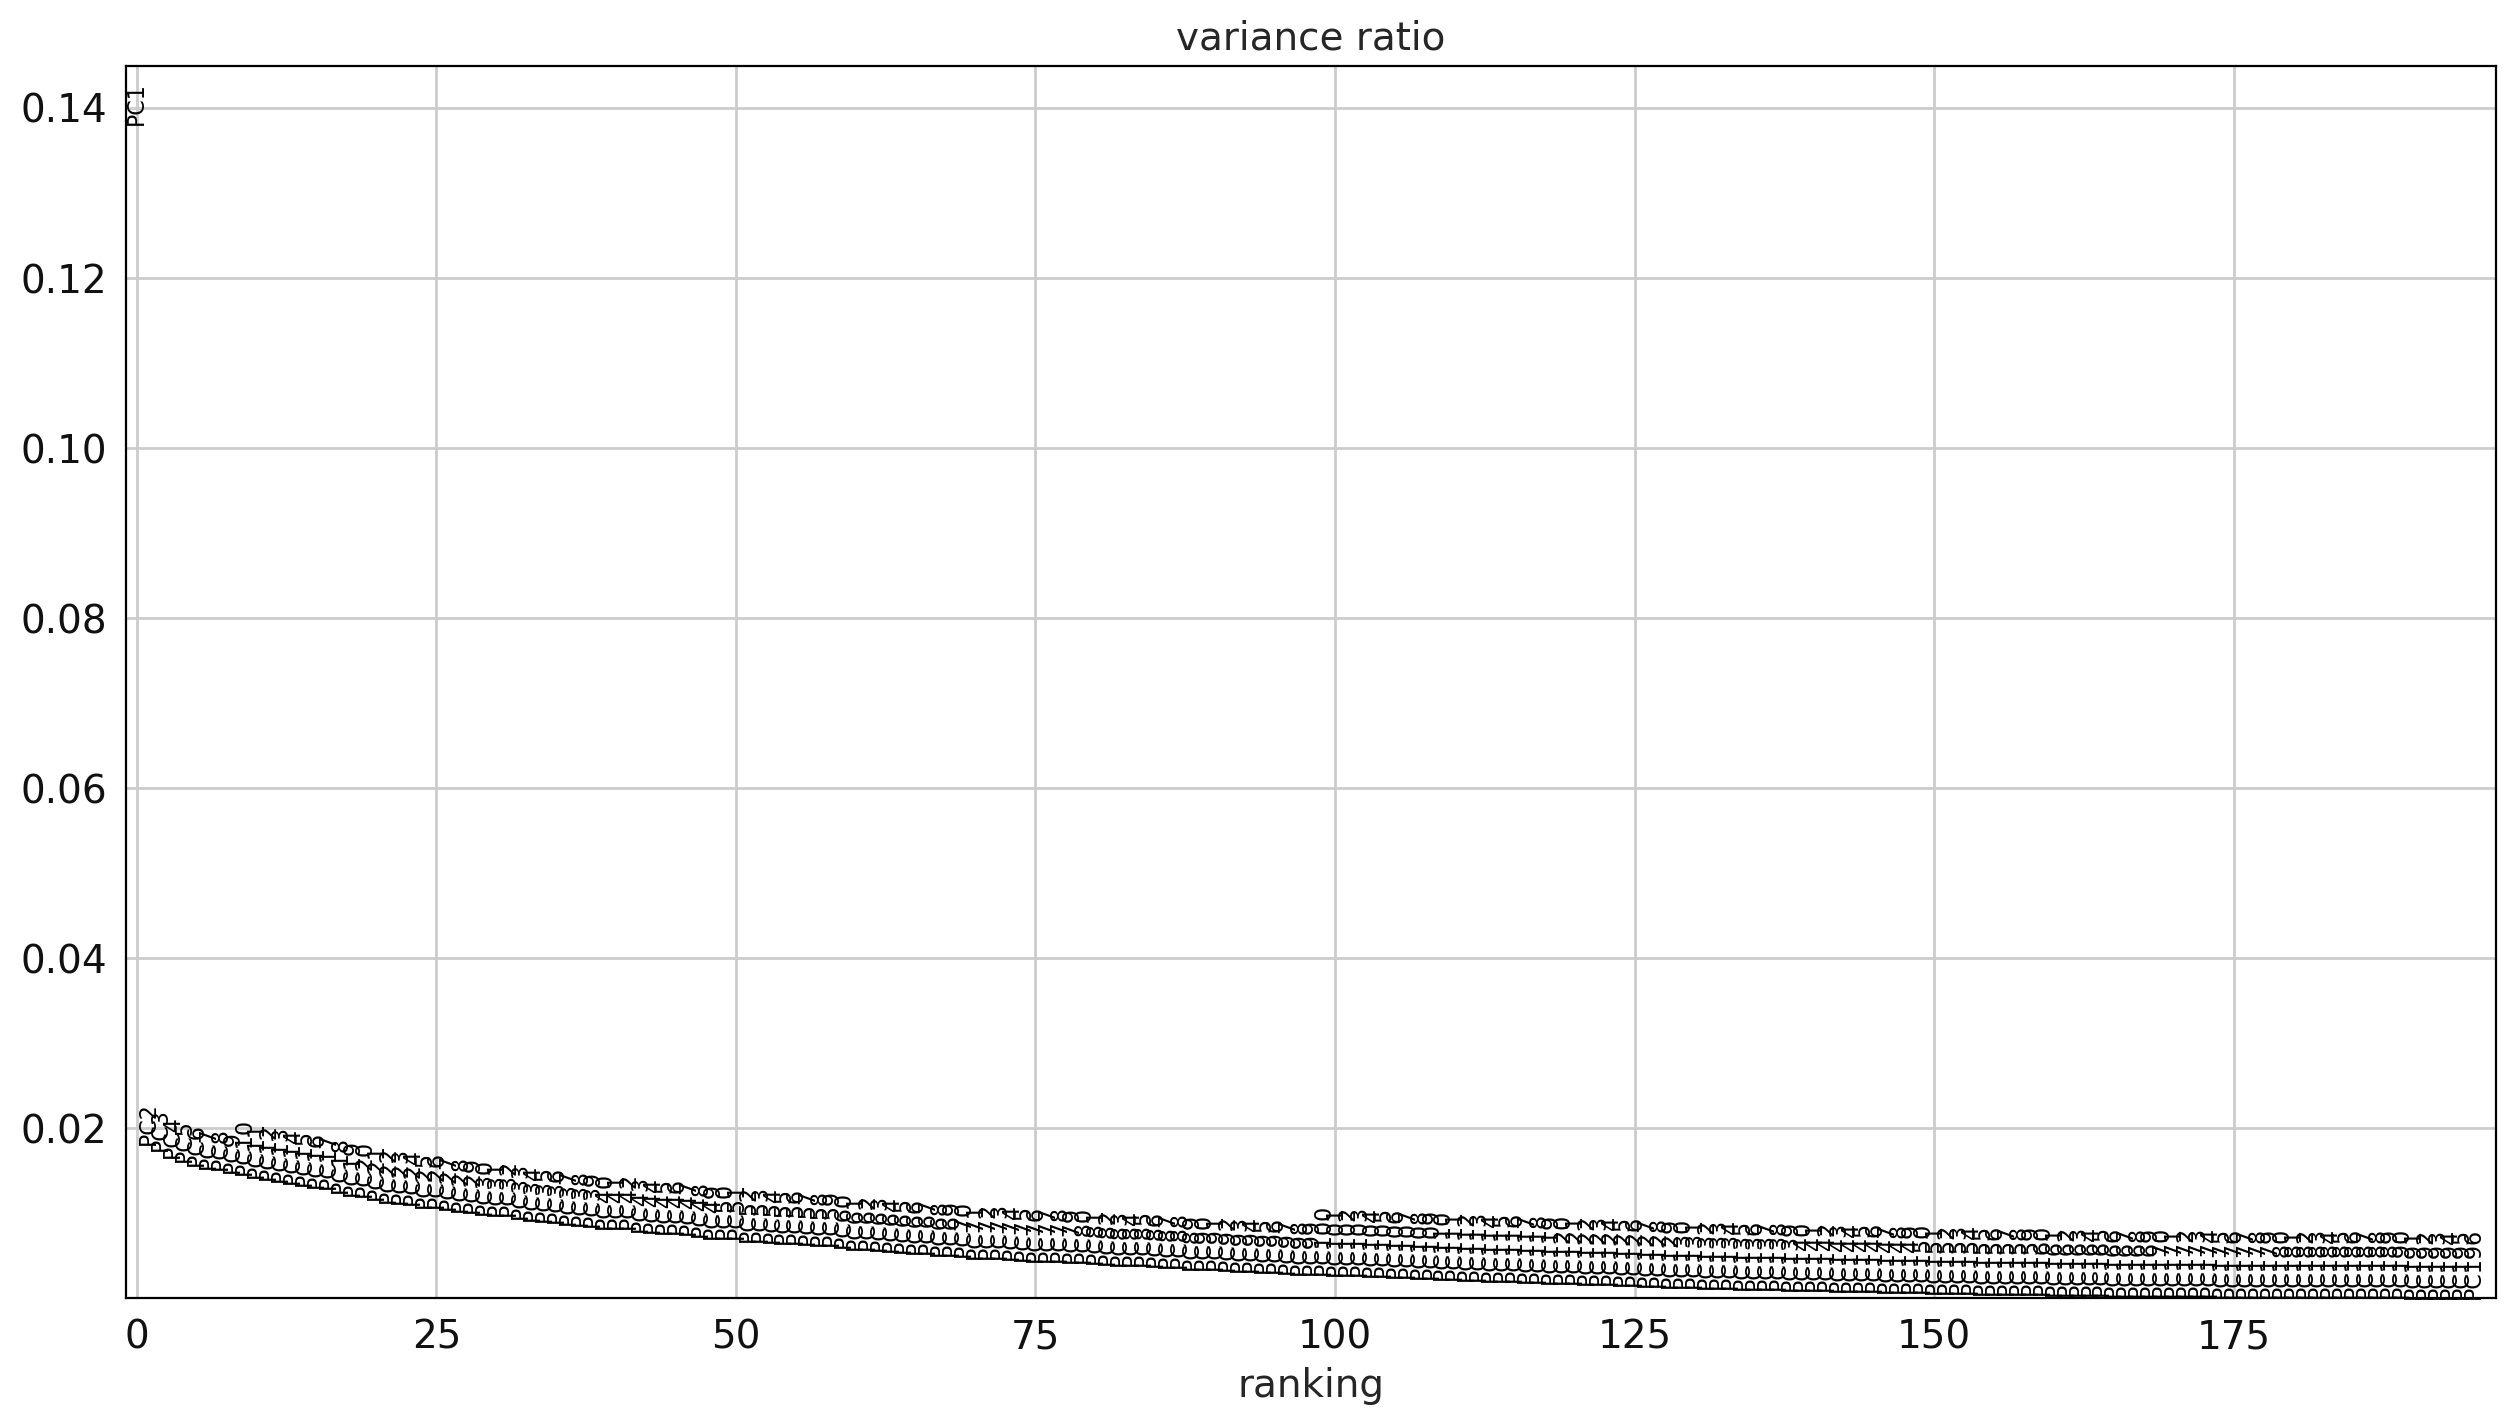

In [107]:
plt.rcParams['figure.figsize'] = (15, 8)  

sc.pl.pca_variance_ratio(adata_pca, n_pcs=n_numb-1 )

plt.show()

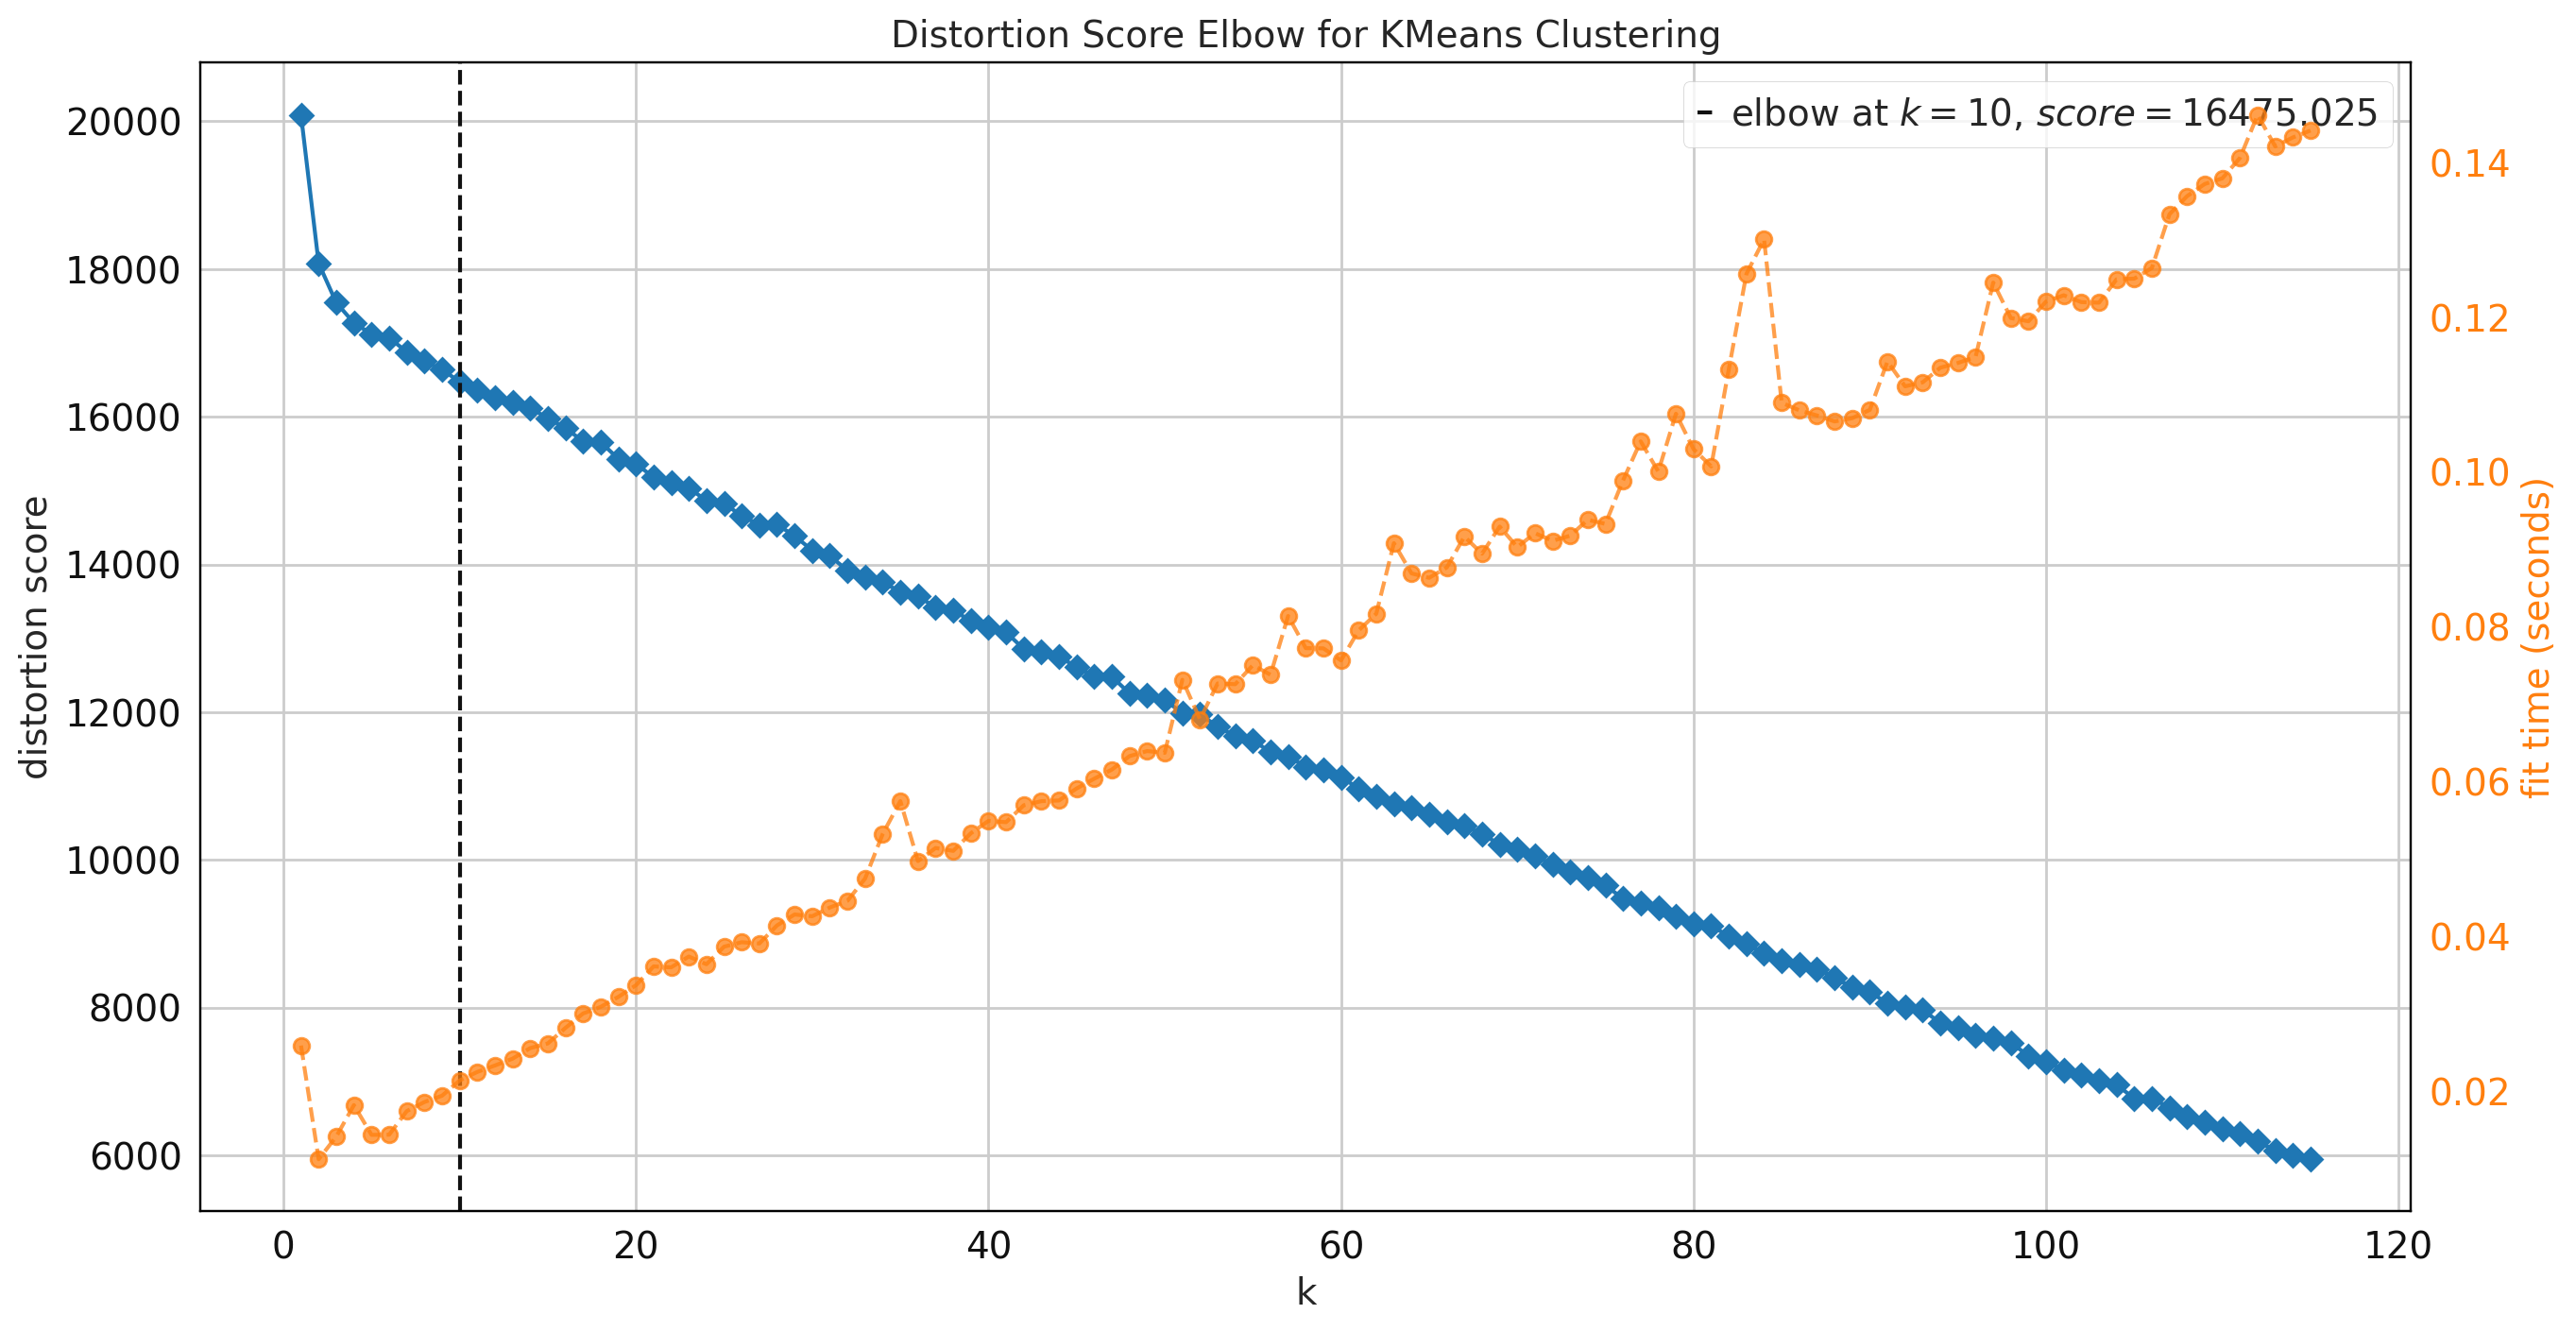

Selected value for the elbow rule: 10


In [108]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, n_components_95))

visualizer.fit(adata_pca.X)  
visualizer.show()

elbow_rule = visualizer.elbow_value_
print("Selected value for the elbow rule:", elbow_rule)

### Kaizer's rule ###

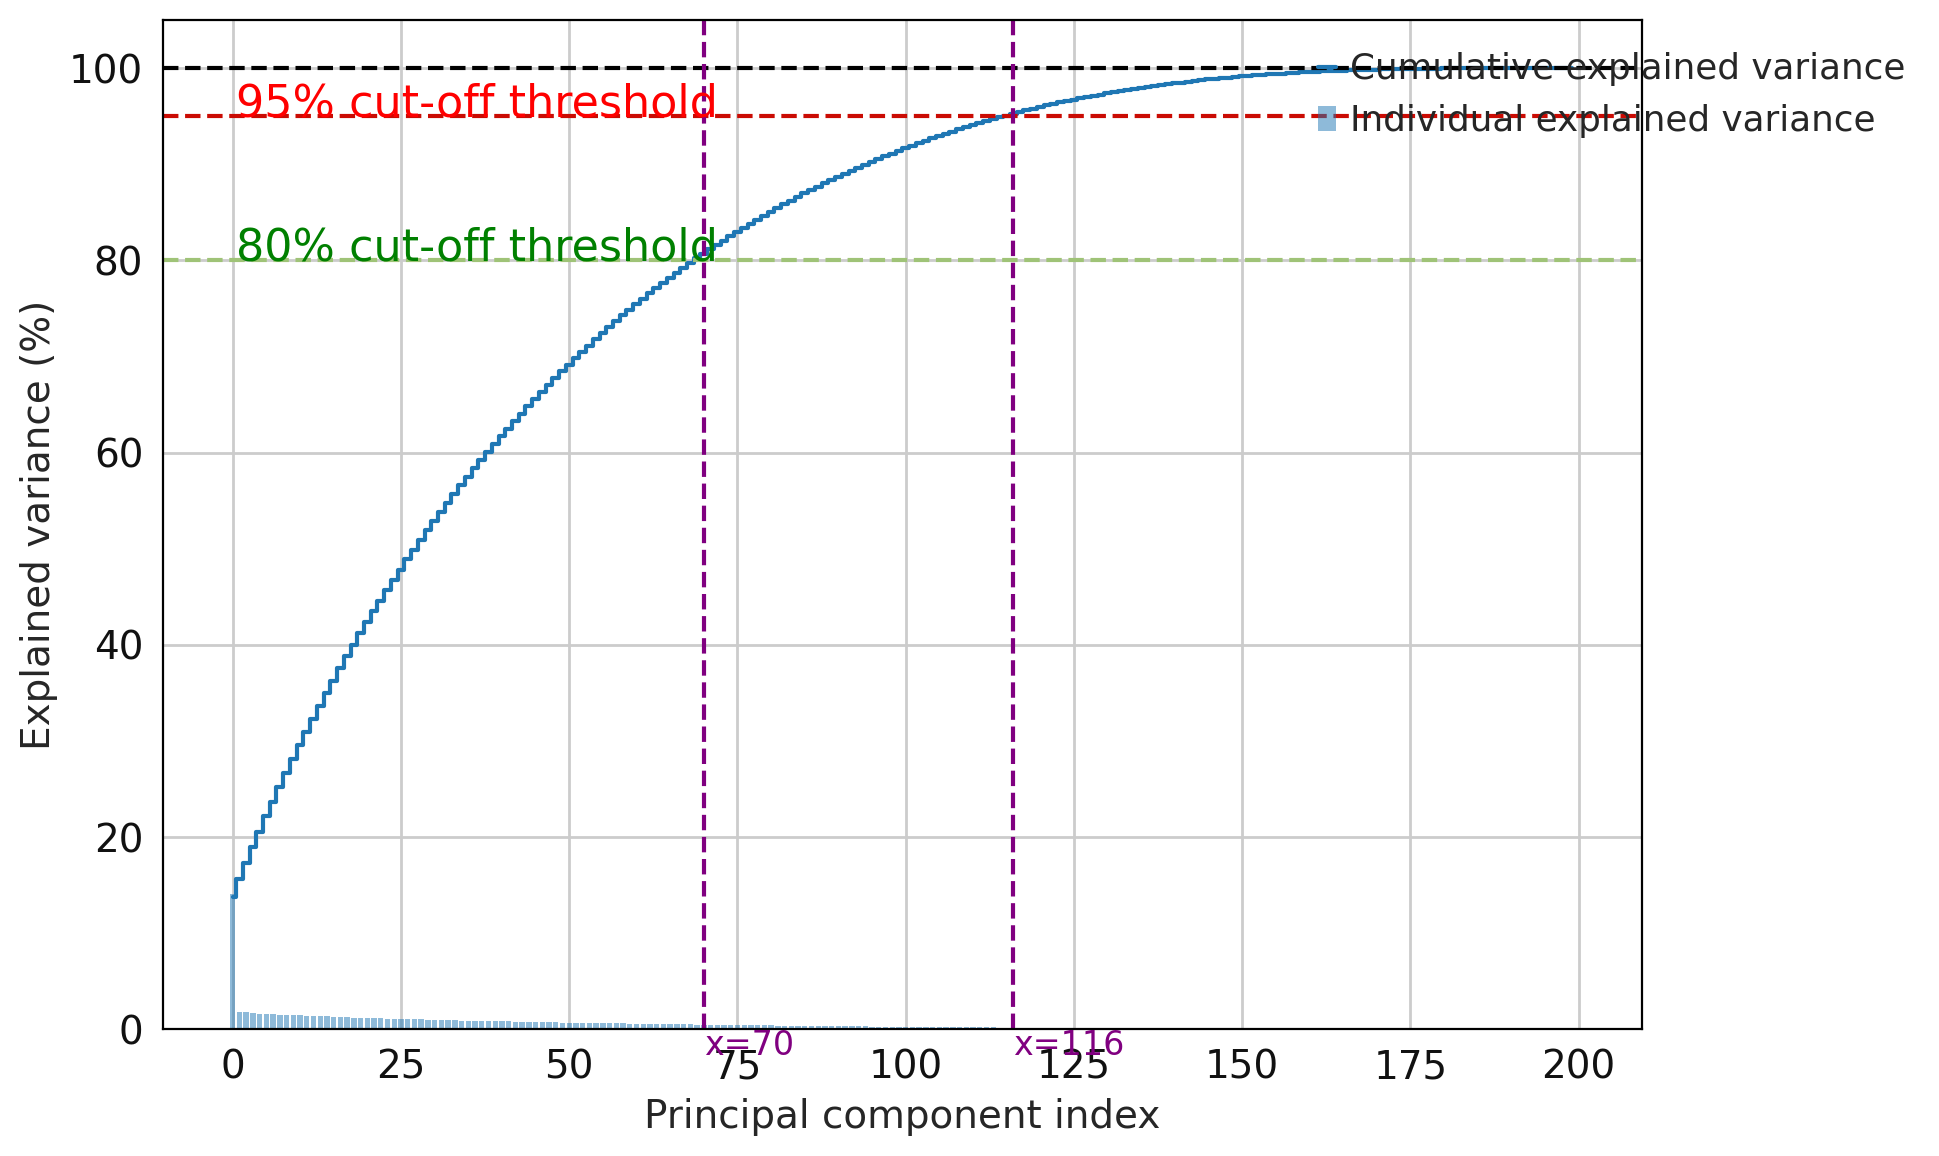

In [109]:
cov_matrix = np.cov(adata_wQC.X, rowvar=False)

eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]

cumulative_variance = np.cumsum(sorted_eigenvalue) / np.sum(sorted_eigenvalue) * 100

plt.figure(figsize=(10, 6))

plt.bar(range(0, sorted_eigenvalue.shape[0]), sorted_eigenvalue, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, cumulative_variance.shape[0]), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance (%)')
plt.xlabel('Principal component index')

plt.axhline(y=100, color='black', linestyle='--')
plt.axhline(y=95, color='r', linestyle='--')
plt.text(0.5, 95, '95% cut-off threshold', color='red', fontsize=16)
plt.axhline(y=80, color='g', linestyle='--')
plt.text(0.5, 80, '80% cut-off threshold', color='green', fontsize=16)
plt.axvline(x = n_components_95, color='purple', linestyle='--')
plt.text(n_components_95, plt.ylim()[0], f'x={n_components_95}', color='purple', fontsize=12, va='top')
plt.axvline(x = n_components_80, color='purple', linestyle='--')
plt.text(n_components_80, plt.ylim()[0], f'x={n_components_80}', color='purple', fontsize=12, va='top')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()


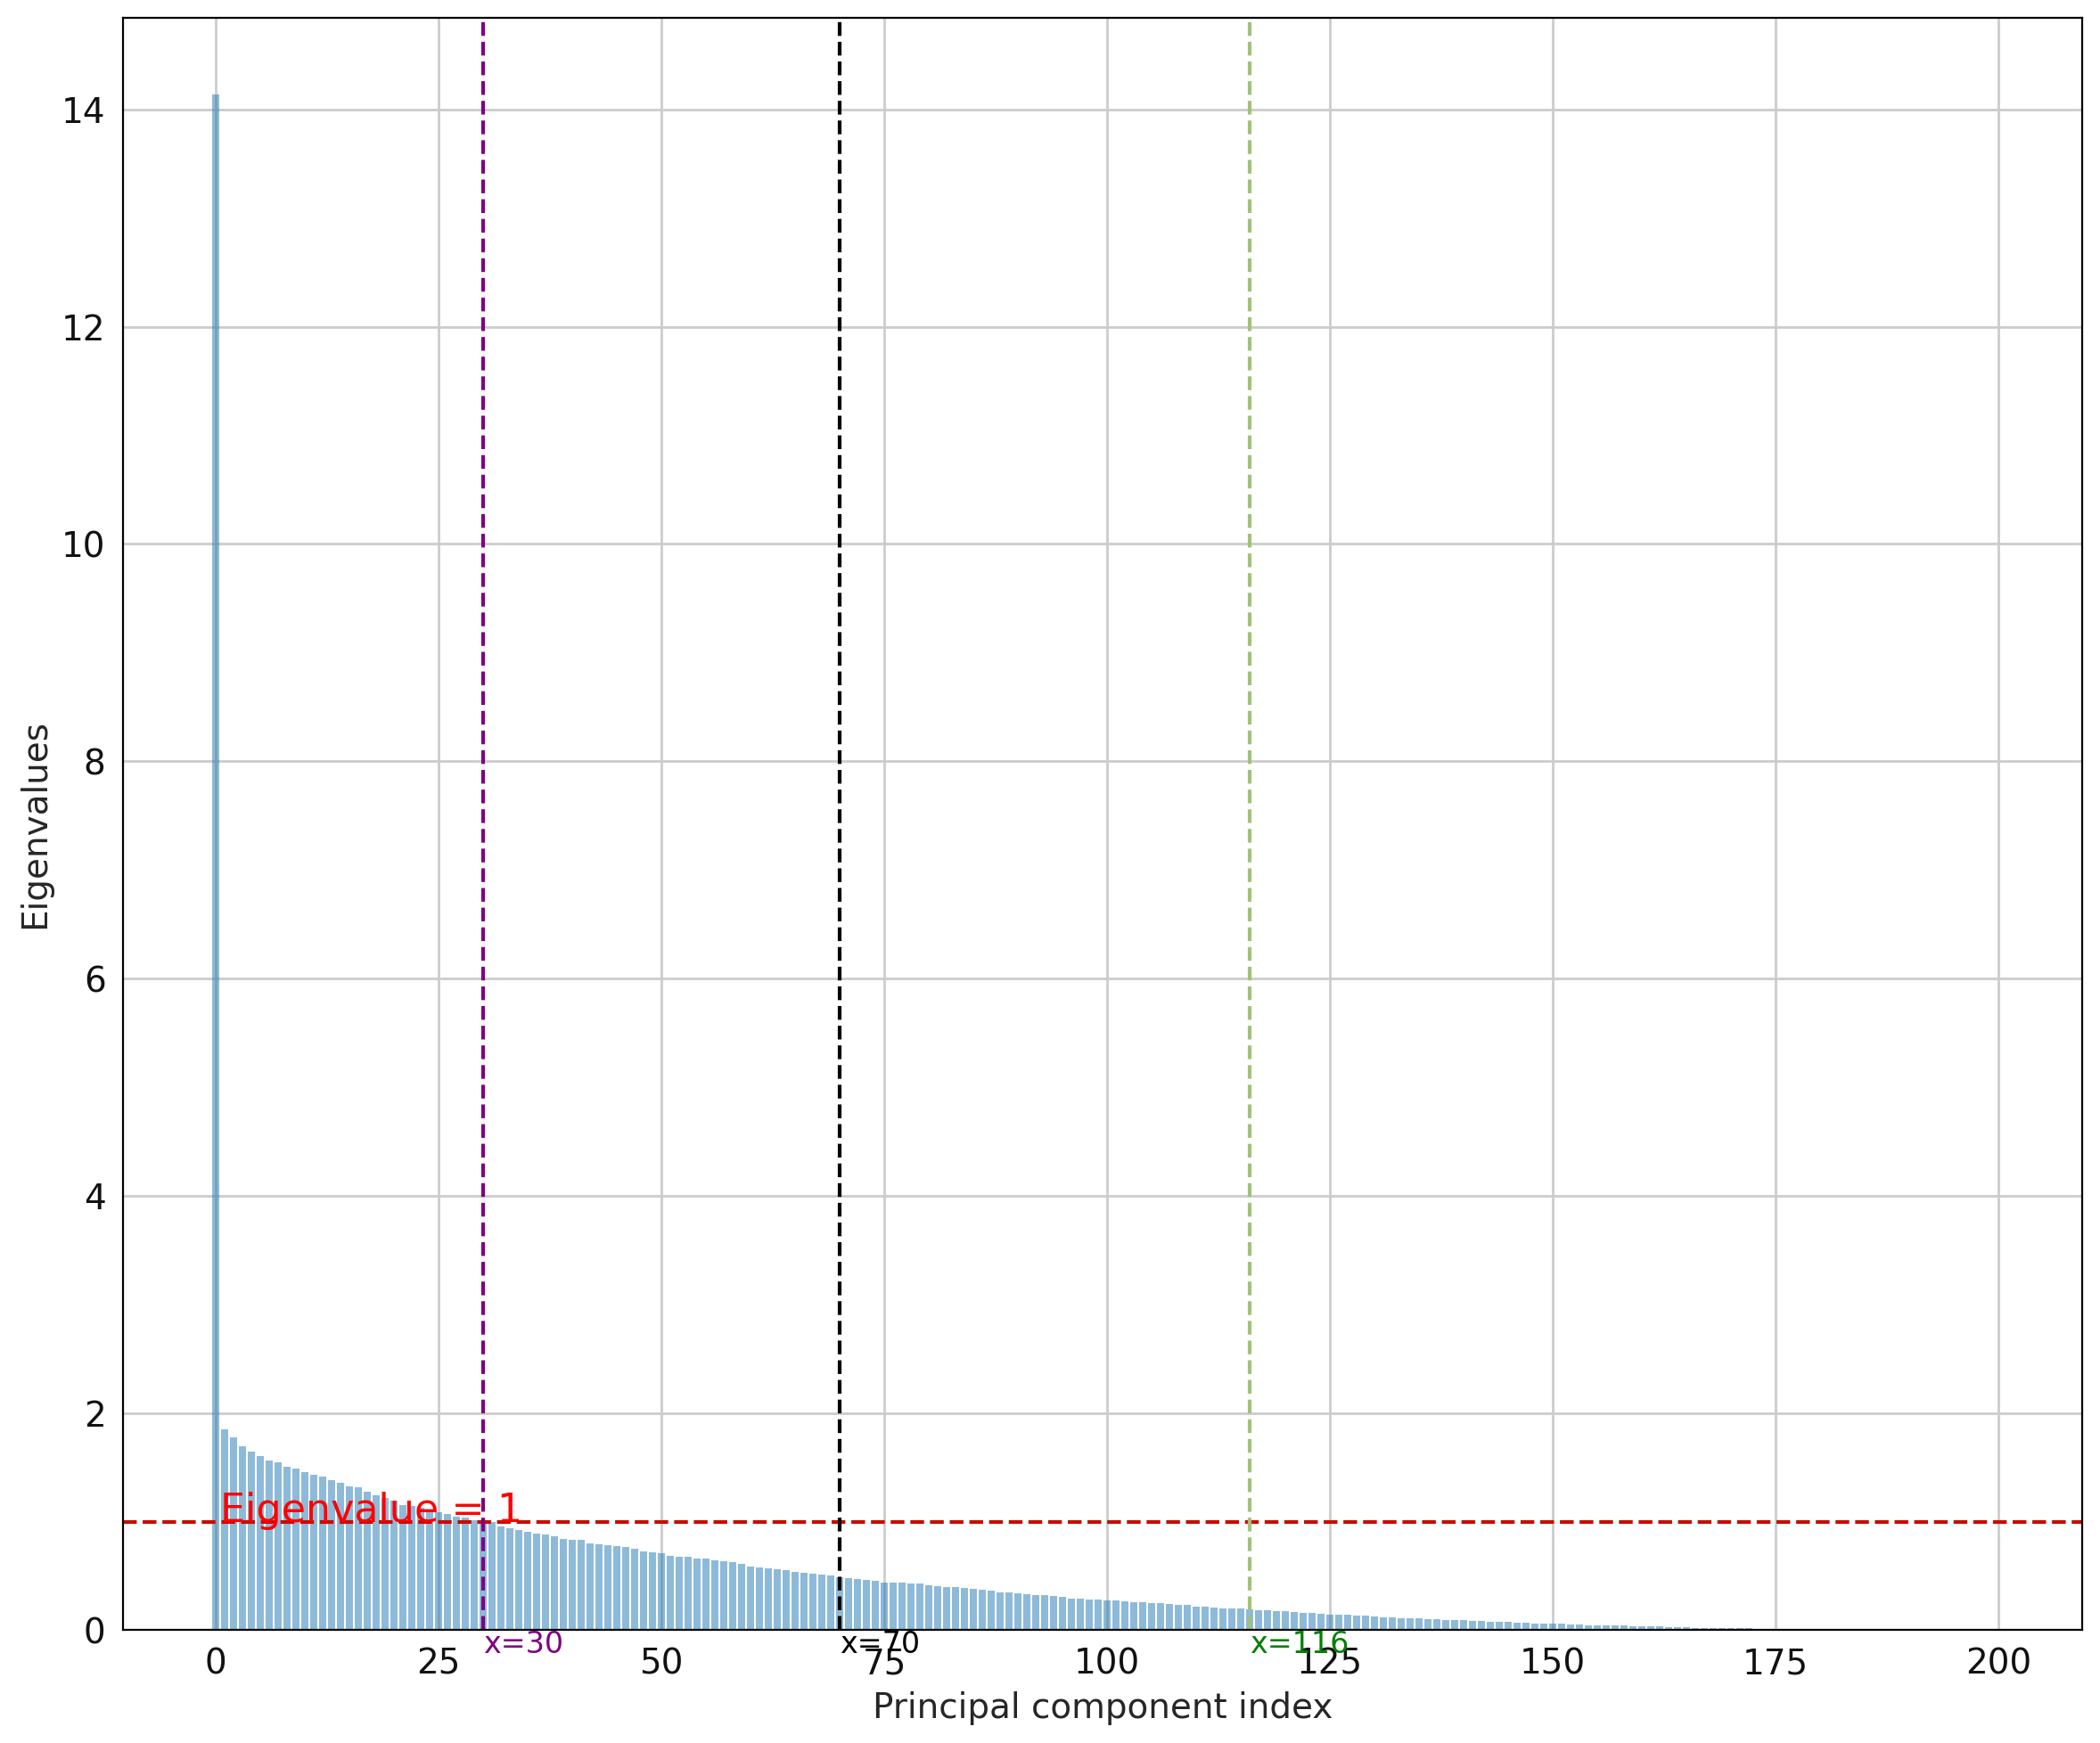

In [110]:
plt.figure(figsize=(12, 10))

plt.bar(range(sorted_eigenvalue.shape[0]), sorted_eigenvalue, alpha=0.5, align='center')
plt.ylabel('Eigenvalues')
plt.xlabel('Principal component index')

plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.5, 1, 'Eigenvalue = 1', color='red', fontsize=16)

plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.text(n_components_95, plt.ylim()[0], f'x={n_components_95}', color='green', fontsize=12, va='top')

plt.axvline(x=n_components_80, color='black', linestyle='--')
plt.text(n_components_80, plt.ylim()[0], f'x={n_components_80}', color='black', fontsize=12, va='top')

kaizer = np.where(sorted_eigenvalue <= 1)[0][0]
plt.axvline(x = kaizer, color='purple', linestyle='--')
plt.text(kaizer, plt.ylim()[0], f'x={kaizer}', color='purple', fontsize=12, va='top')

plt.tight_layout()
plt.show()

In [111]:
 final_comp = min(kaizer, n_components_80, n_components_95, elbow_rule)

In [112]:
sc.tl.pca(adata_pca, svd_solver='arpack' , n_comps = final_comp, use_highly_variable=False) 

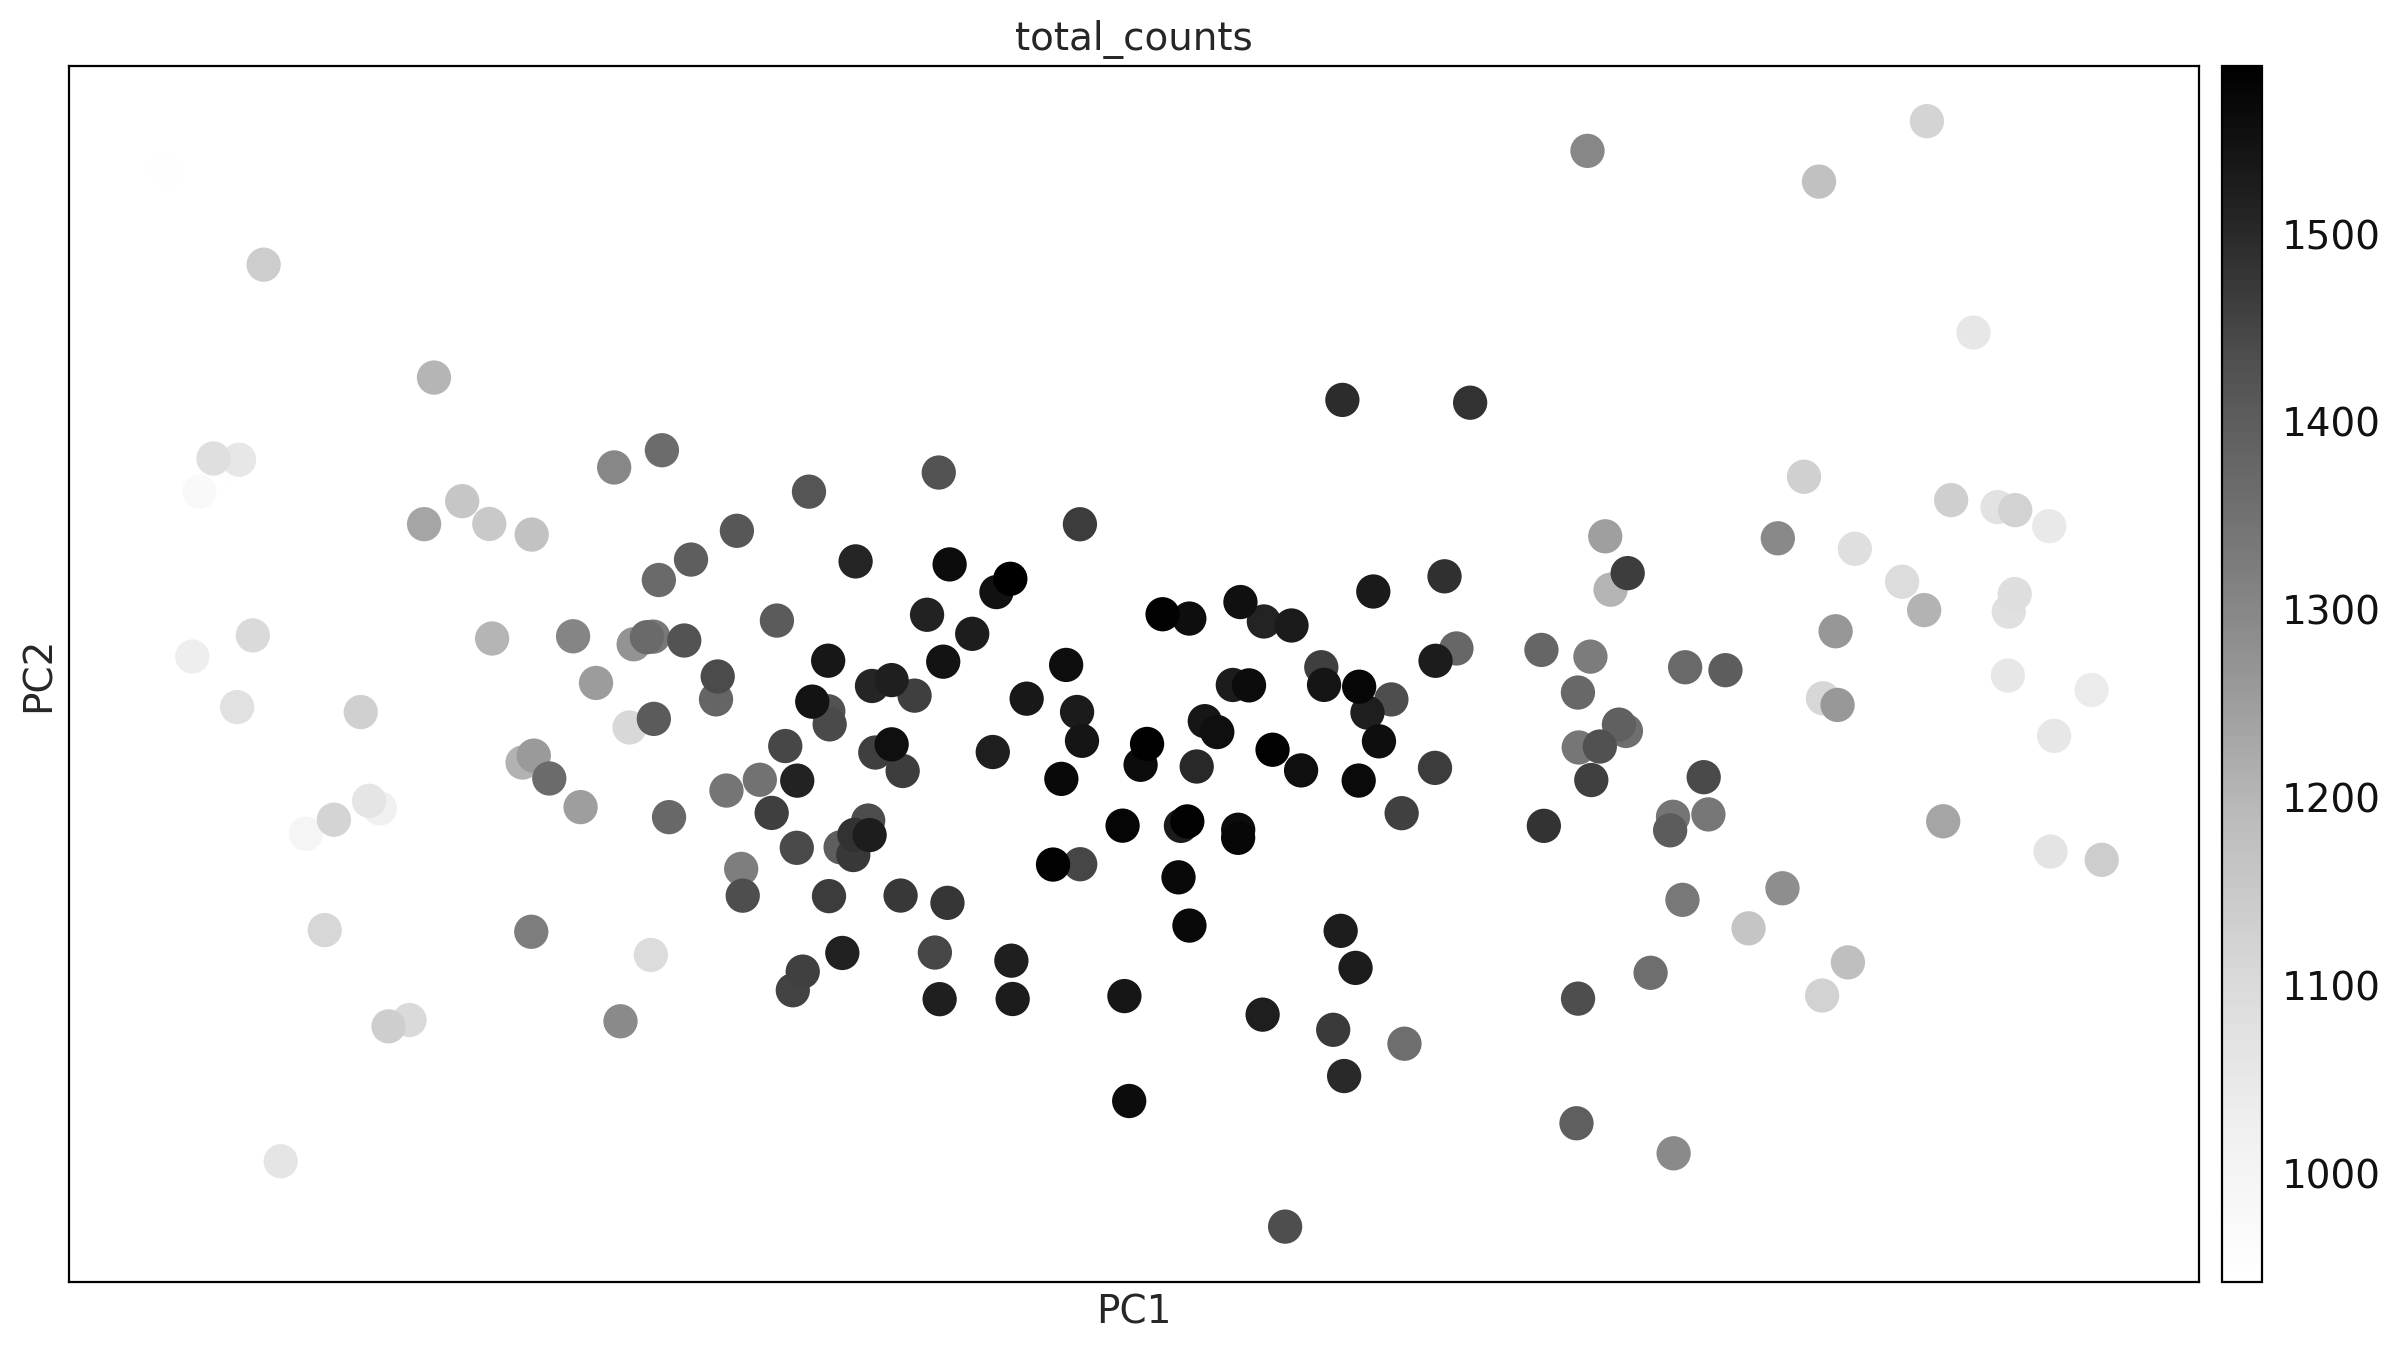

In [113]:
sc.pl.pca(adata_pca, color='total_counts')

## TSNE ##

In [114]:
# adata_tsne = adata_pca.copy()

In [115]:
# param_grid = {'n_pcs': [2], 
#         'learning_rate': [200,400,600,800,1000], 'use_rep' : ['X_pca'],
#          'perplexity':[10,20,30,40,50]}

# for params in ParameterGrid(param_grid):
#     sc.tl.tsne(adata_tsne, **params)
#     title ='TSNE'+'_'+ str(params['learning_rate']) +'_'+str(params['n_pcs'])+'_'+str(params['perplexity'])
#     sc.pl.tsne(adata_tsne, color="total_counts", title=title)


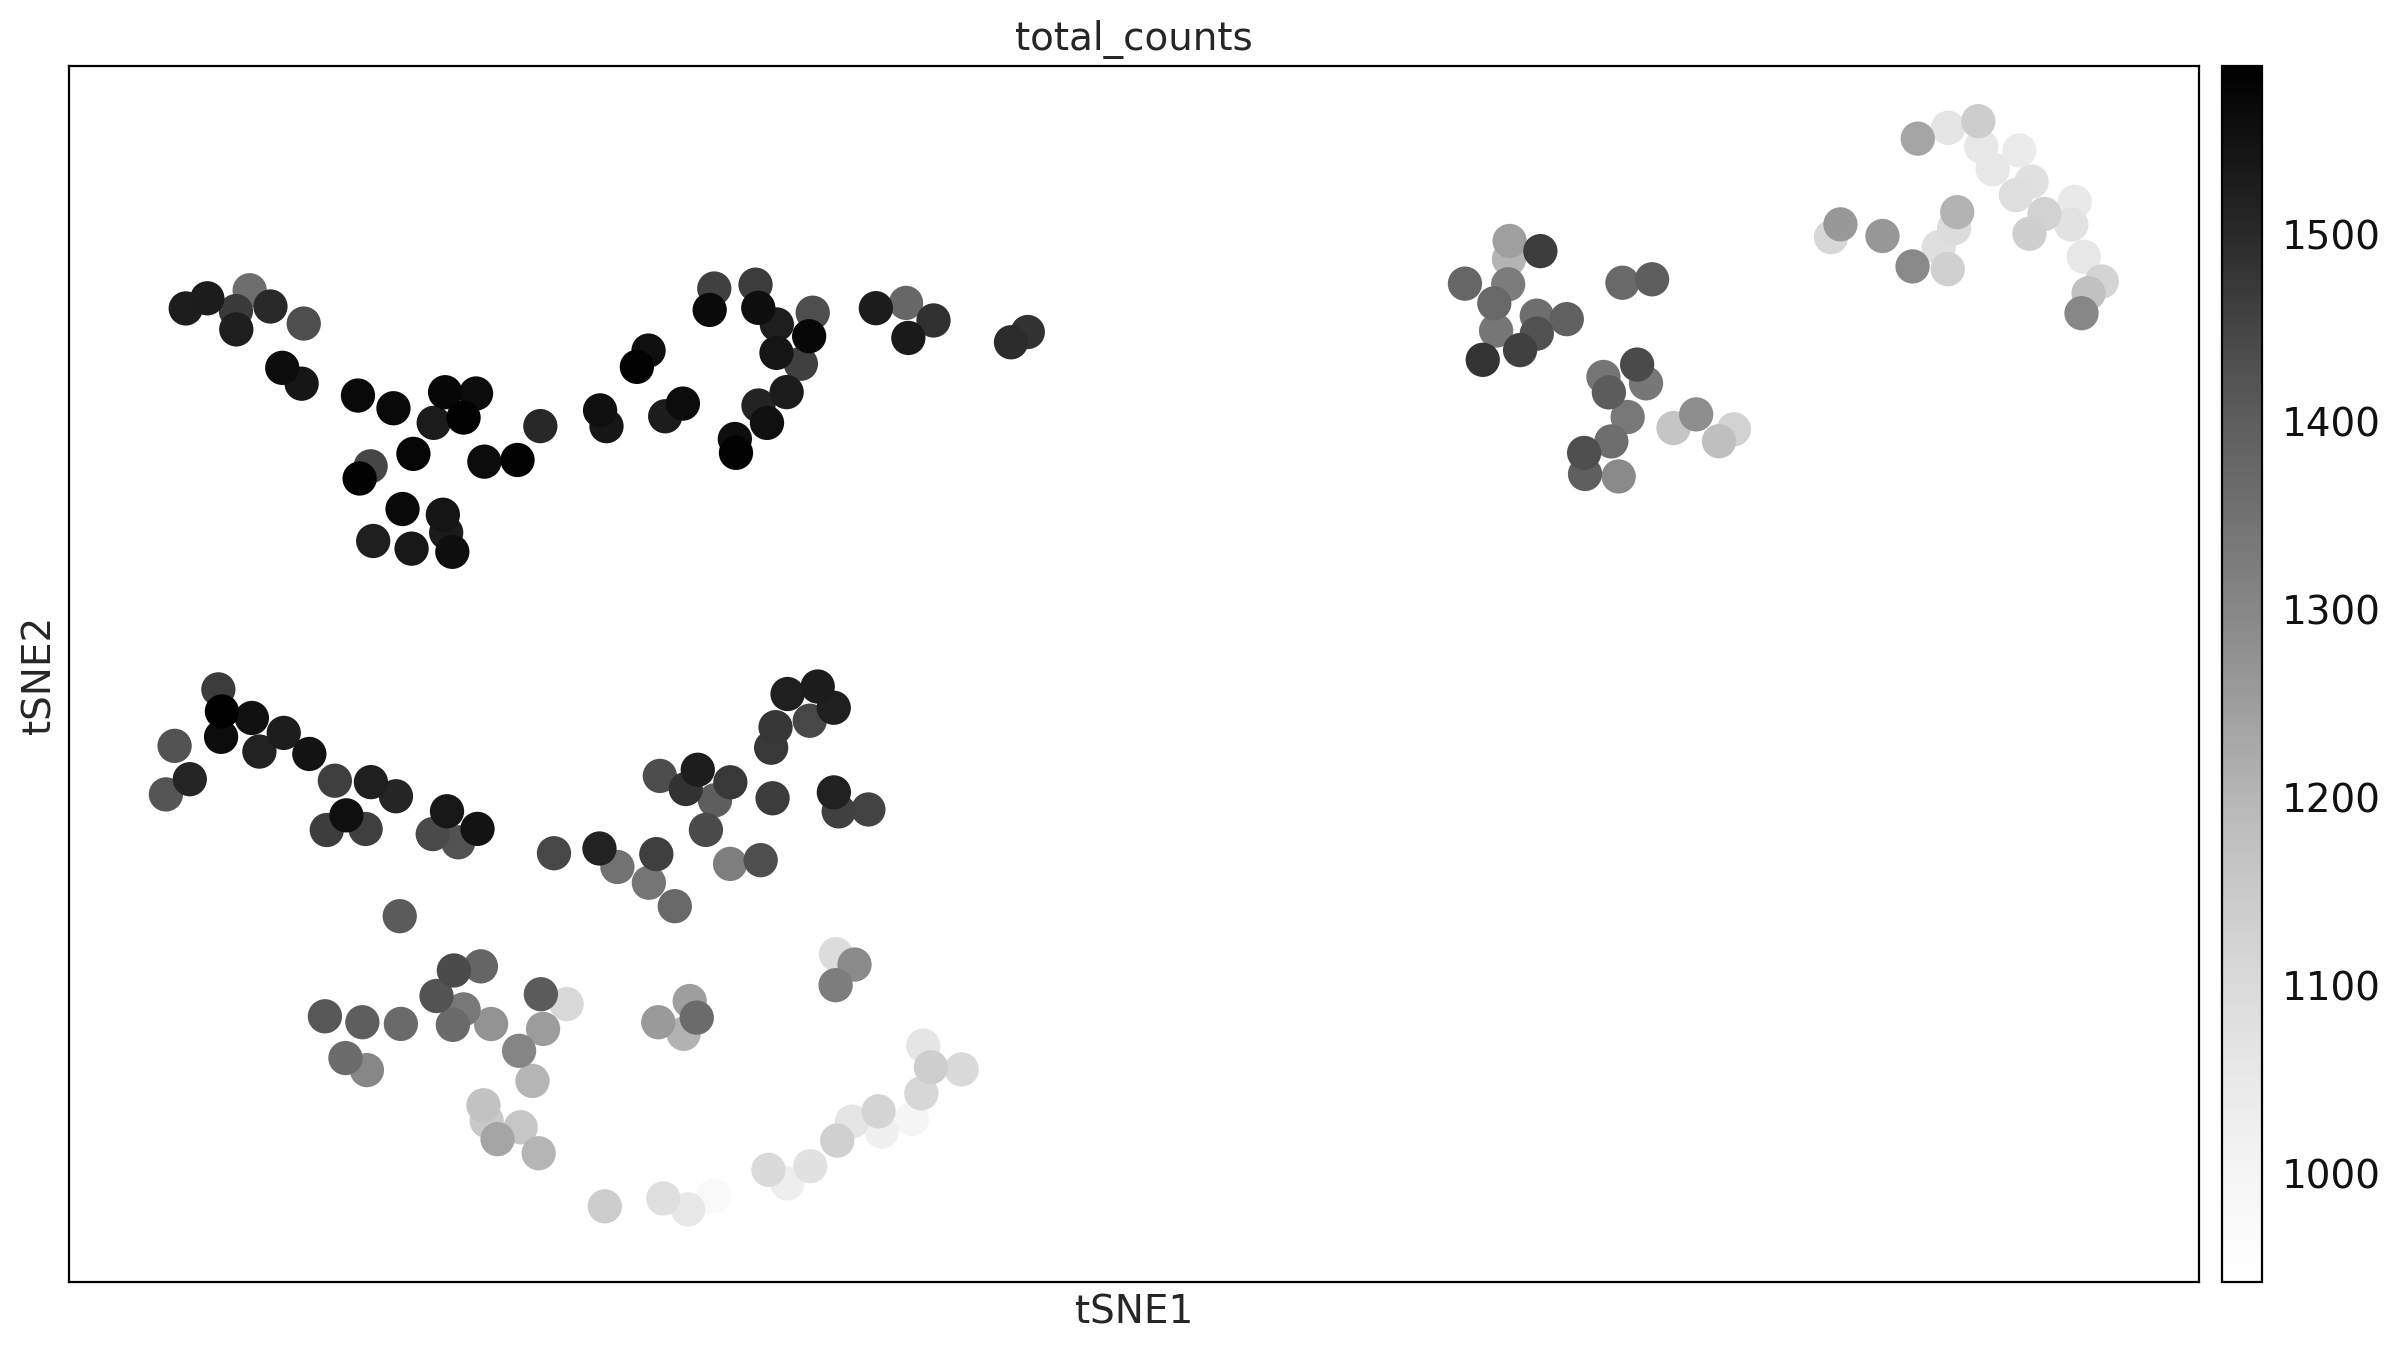

In [116]:
adata_tsne_pca = adata_pca.copy()
sc.tl.tsne(adata_tsne_pca, learning_rate =400, n_pcs= 2, perplexity = 10)
sc.pl.tsne(adata_tsne_pca, color="total_counts")

## UMAP ##

In [117]:
# adata_umap = adata_tsne_pca.copy()

In [118]:
# param_grid_nei = {'n_pcs': [2,3,4,final_comp],'use_rep':[None],
#         'n_neighbors': [5,10,15,20]}
# param_grid_umap = {'min_dist':[0,0.25,0.5]}

# for params in ParameterGrid(param_grid_nei):
#   for params_umap in ParameterGrid(param_grid_umap):
#     sc.pp.neighbors(adata_umap, **params)
#     sc.tl.umap(adata_umap,**params_umap)
#     title ='UMAP'+'_'+  str(params['n_neighbors'])+'_'+  str(params['n_pcs'])+'_'+ str(params_umap['min_dist'])
#     sc.pl.umap(adata_umap, color="total_counts", title=title)

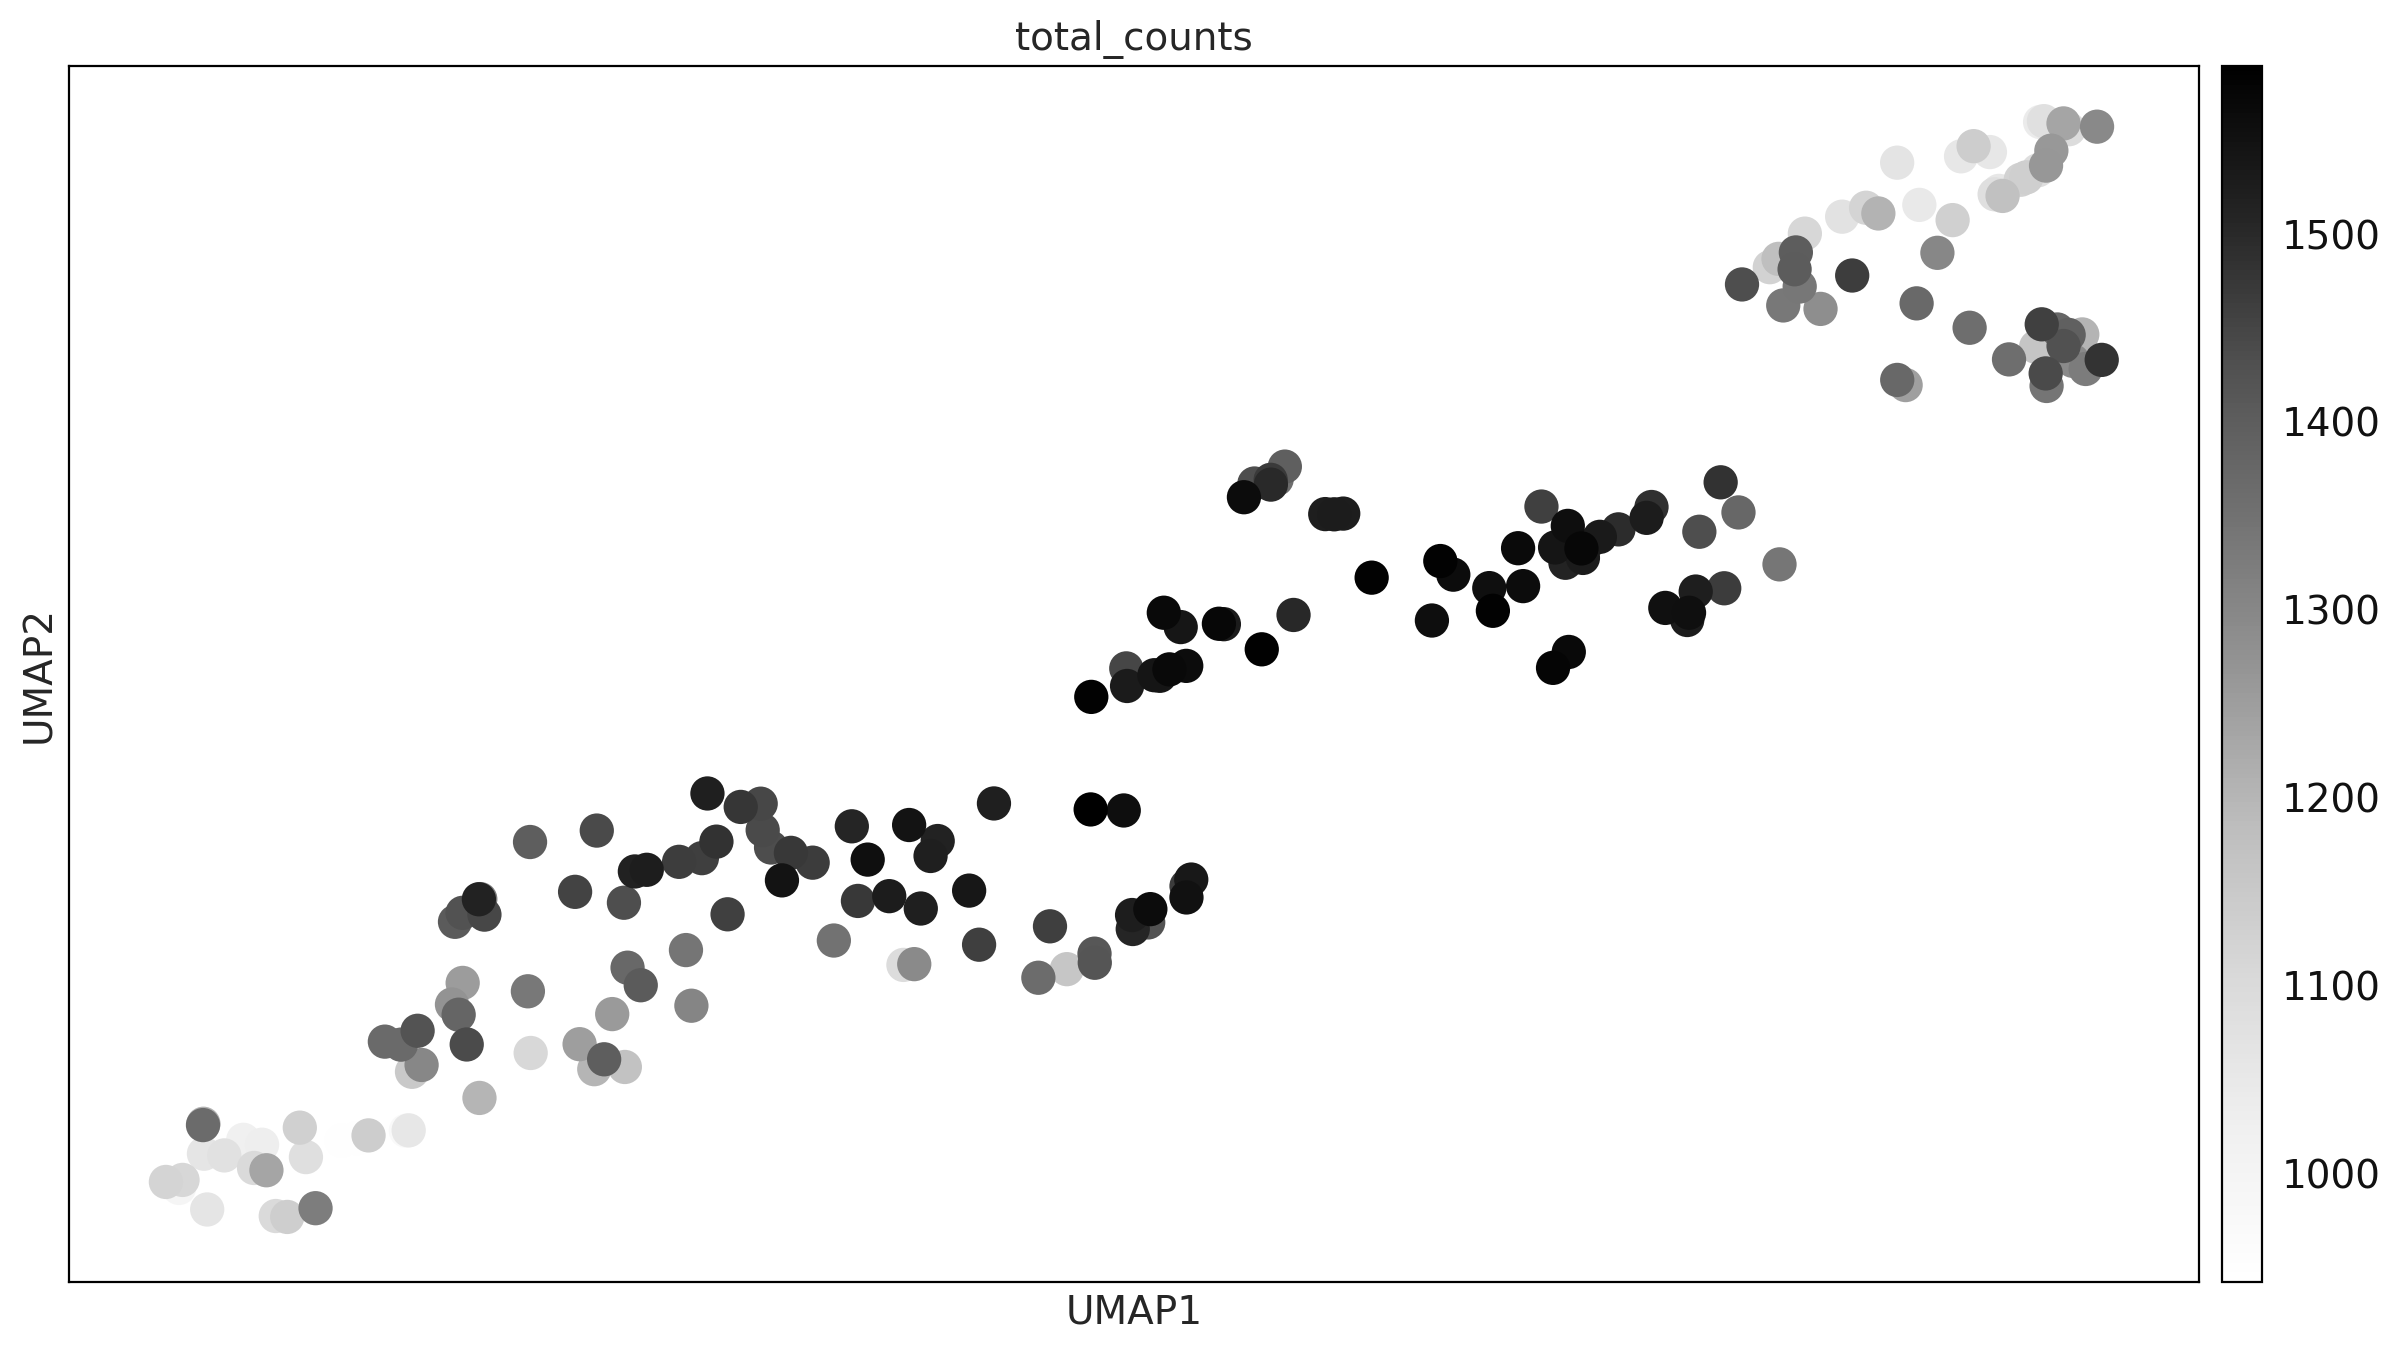

In [119]:
adata_all_dr = adata_tsne_pca.copy()
sc.pp.neighbors(adata_all_dr, n_pcs = 4,n_neighbors=15)
sc.tl.umap(adata_all_dr,min_dist=0)
sc.pl.umap(adata_all_dr, color='total_counts')

# Clustering #

In [120]:
adata_gmm = adata_all_dr.copy()
adata_gmm

AnnData object with n_obs × n_vars = 197 × 200
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm'
    obsp: 'distances', 'connectivities'

## GMM for PCA ##


In [121]:
def find_best_gmm_parameters(data, dim_reduction, components_trials):
    reduced_data = data.obsm[dim_reduction]
    n_components_list = list(range(1, components_trials+1))

    param_grid = {
        'n_components': n_components_list,
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'reg_covar': [1e-04, 1e-03, 1e-02, 1e-01],
        'n_init': [1,10]
    }

    best_bic_score = float('inf')

    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(**params)
        gmm.fit(reduced_data)
        bic_score = gmm.bic(reduced_data)
        if bic_score < best_bic_score:
            best_bic_score = bic_score
            best_params = params

    return reduced_data, best_params, best_bic_score

In [122]:
def bic_plot(data,max_comp,cov_type,n_init,reg_covar):
    n_components_range = range(1, max_comp+1)
    bic_values = []
    aic_values = []

    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cov_type, n_init=n_init, reg_covar=reg_covar)
        gmm.fit(data)
        bic = gmm.bic(data)
        aic = gmm.aic(data)
        bic_values.append(bic)
        aic_values.append(aic)

    plt.plot(n_components_range, bic_values, marker='o', label='BIC')
    plt.plot(n_components_range, aic_values, marker='o', label='AIC')
    plt.xlabel('Number of Components')
    plt.ylabel('Information Criterion')
    plt.title('BIC and AIC Plot')
    plt.legend()
    plt.show()

In [123]:
def plot_results(gmm, X, title):
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = ["navy", "c", "cornflowerblue", "gold", "darkorange", "purple", "lime", "pink", "teal", "magenta"]
    color_iter = itertools.cycle(colors)

    for n, color in enumerate(colors[:gmm.n_components]):
        mean = gmm.means_[n, :2]
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    ax.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), cmap='viridis', s=10)
    
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='x', label='Means')
    
    ax.set_xlim([X[:, 0].min() - 1, X[:, 0].max() + 1])
    ax.set_ylim([X[:, 1].min() - 1, X[:, 1].max() + 1])
    plt.title(title)
    plt.legend()
    plt.show()


In [124]:
reduced_data_pca ,best_params_pca, best_bic_score_pca  = find_best_gmm_parameters(adata_gmm, 'X_pca', 8)
print("Best Parameters:", best_params_pca)
print("Best BIC Score:", best_bic_score_pca)

Best Parameters: {'covariance_type': 'spherical', 'n_components': 5, 'n_init': 10, 'reg_covar': 0.001}
Best BIC Score: 7043.673103921207


In [125]:
gmm_optimal_pca = GaussianMixture(**best_params_pca)
gmm_optimal_pca.fit(reduced_data_pca)
covariances_pca = gmm_optimal_pca.covariances_
# posterior_probs_pca = gmm_optimal_pca.predict_proba(reduced_data_pca)

In [126]:
results_df = pd.DataFrame({'n_components': [best_params_pca['n_components']],
                           'covariance_type': [best_params_pca['covariance_type']],
                           'reg_covar': [best_params_pca['reg_covar']],
                           'n_init': [best_params_pca['n_init']],
                           'bic_score': [best_bic_score_pca],
                           'covariances': [covariances_pca],
                           'adata': [reduced_data_pca],
                           'gmm': gmm_optimal_pca,
                           'title': 'PCA'
                           })

results_df

n_components covariance_type  reg_covar  n_init    bic_score  \
0             5       spherical      0.001      10  7043.673104   

                                         covariances  \
0  [1.185734653997816, 1.0993027769087025, 2.1548...   

                                               adata  \
0  [[-0.32677814, 0.4197753, -1.0248446, 0.050844...   

                                                 gmm title  
0  GaussianMixture(covariance_type='spherical', n...   PCA

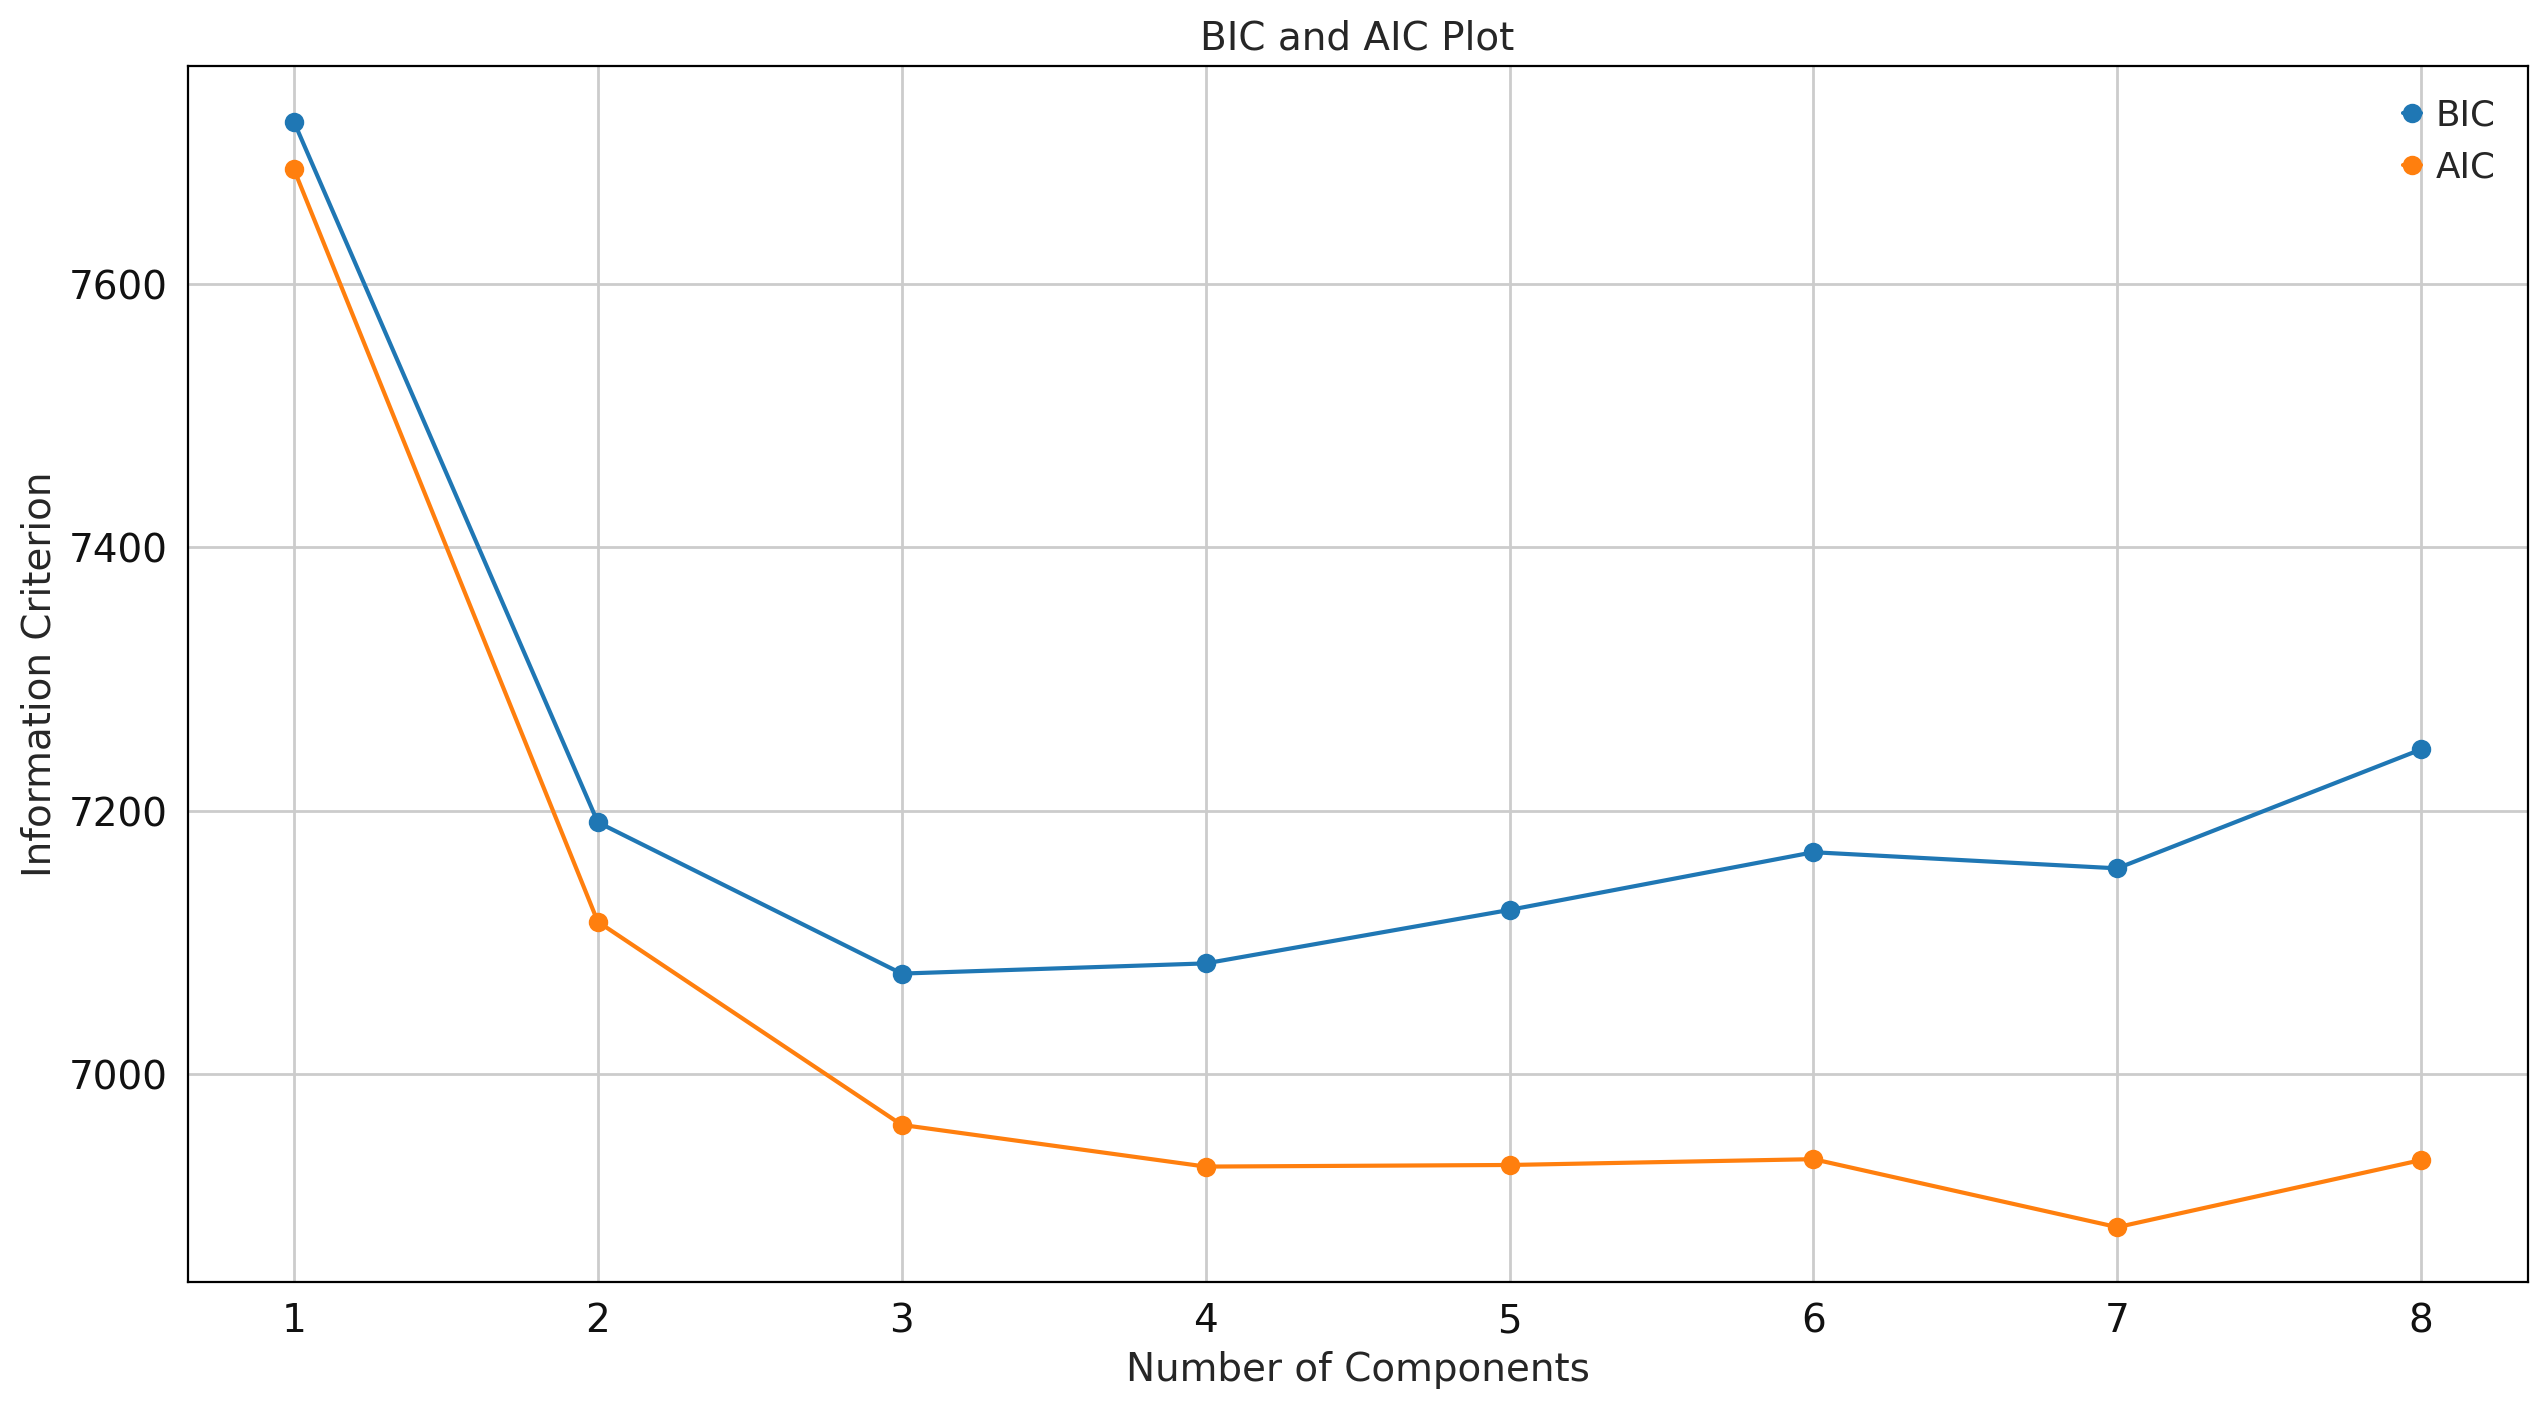

In [127]:
bic_plot(reduced_data_pca,8,results_df.covariance_type[0],results_df.n_init[0],results_df.reg_covar[0])

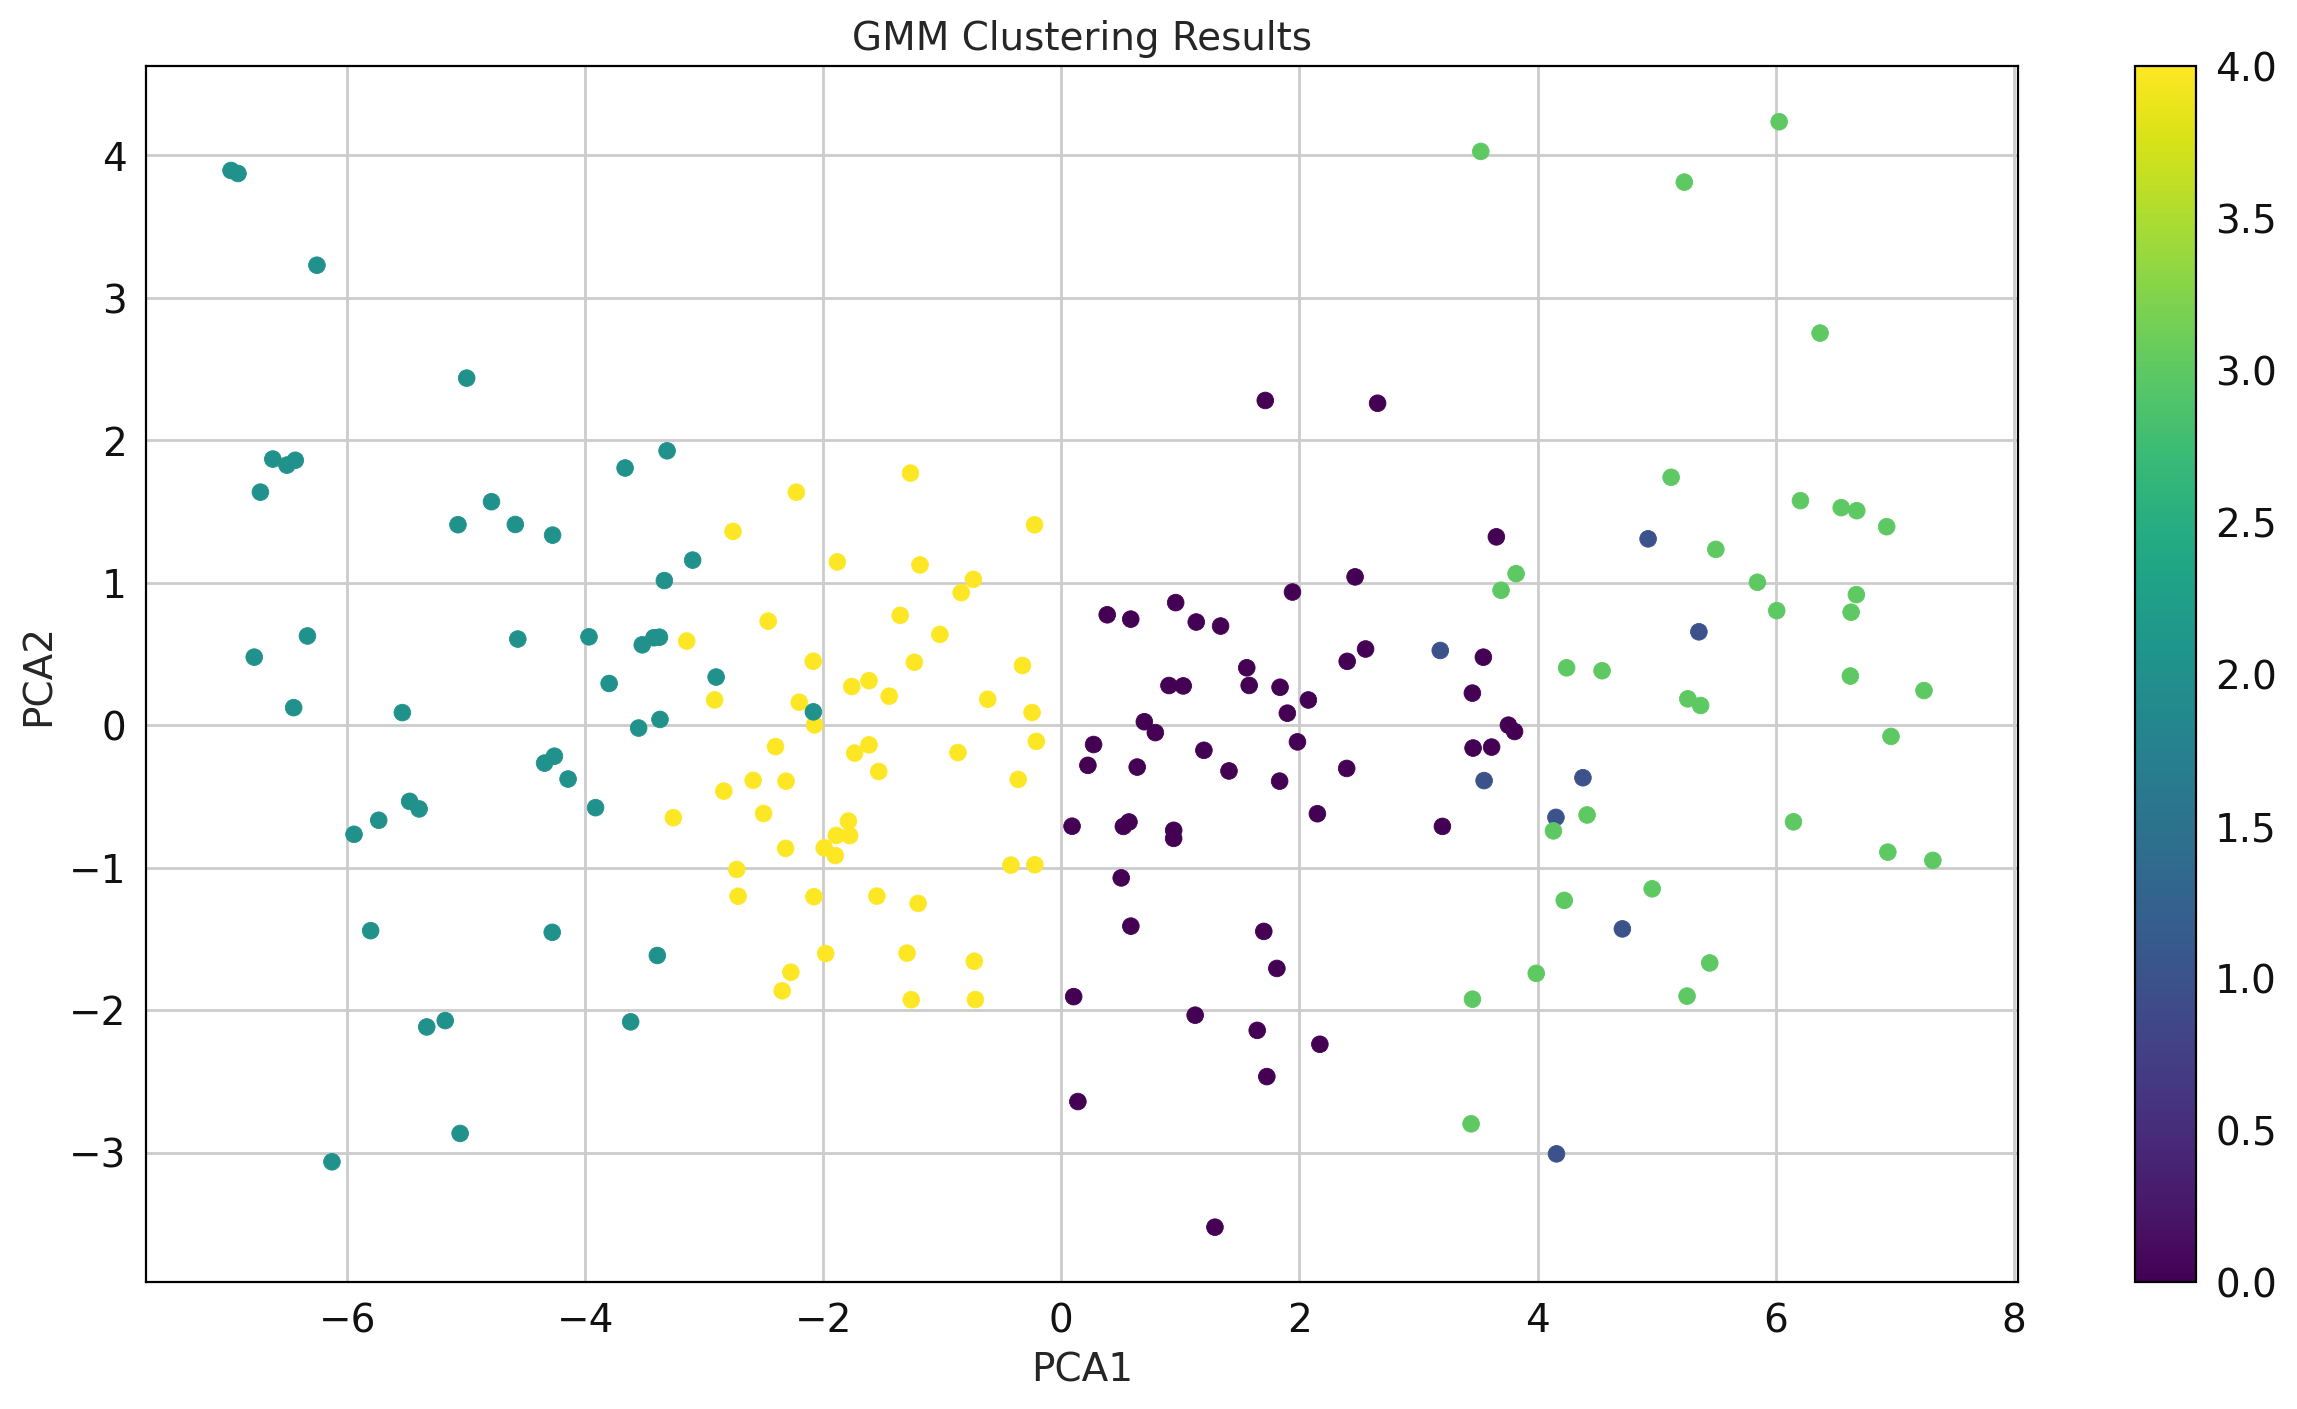

In [128]:
labels = gmm_optimal_pca.predict(reduced_data_pca)

plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('GMM Clustering Results')
plt.colorbar()  

plt.show()

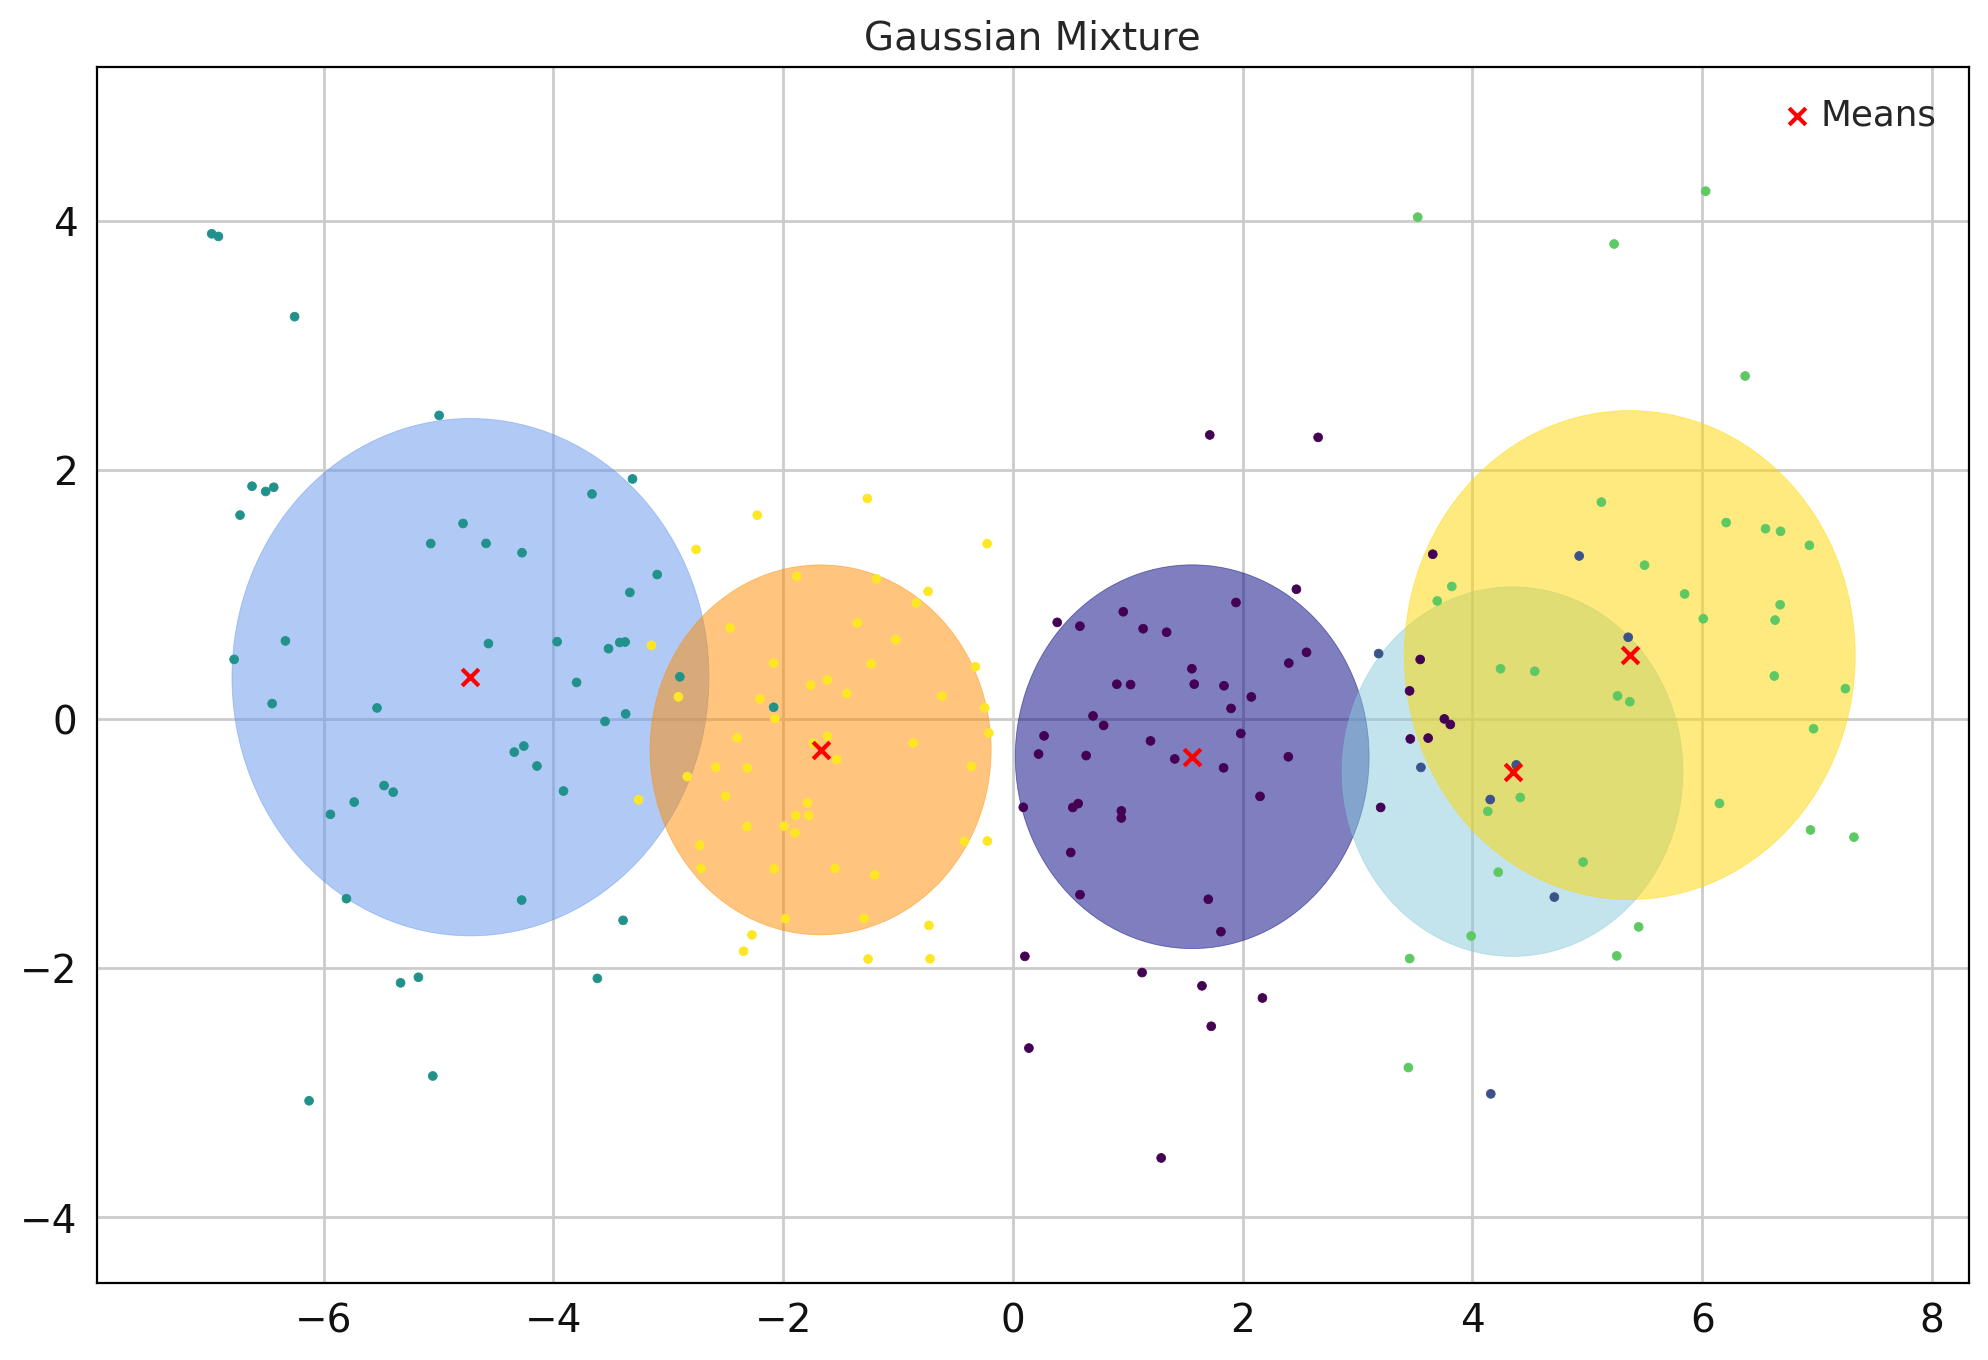

In [129]:
plot_results(gmm_optimal_pca , reduced_data_pca, "Gaussian Mixture")

## GMM for UMAP ##

In [130]:
reduced_data_umap ,best_params_umap, best_bic_score_umap  = find_best_gmm_parameters(adata_gmm, 'X_umap', 10)
print("Best Parameters:", best_params_umap)
print("Best BIC Score:", best_bic_score_umap)

Best Parameters: {'covariance_type': 'tied', 'n_components': 10, 'n_init': 1, 'reg_covar': 0.0001}
Best BIC Score: 1238.9434009240017


In [131]:
gmm_optimal_umap = GaussianMixture(**best_params_umap)
gmm_optimal_umap.fit(reduced_data_umap)
covariances_umap = gmm_optimal_umap.covariances_
posterior_probs_umap = gmm_optimal_umap.predict_proba(reduced_data_umap)

In [132]:
new_row = {
    'n_components': best_params_umap['n_components'],
    'covariance_type': best_params_umap['covariance_type'],
    'reg_covar': best_params_umap['reg_covar'],
    'n_init': best_params_umap['n_init'],
    'bic_score': best_bic_score_umap,
    'covariances': covariances_umap,
    'adata': [reduced_data_umap],
    'gmm': gmm_optimal_umap,
    'title': 'UMAP'
}

results_df = results_df.append(new_row, ignore_index=True)
results_df

n_components covariance_type  reg_covar  n_init    bic_score  \
0             5       spherical     0.0010      10  7043.673104   
1            10            tied     0.0001       1  1238.943401   

                                         covariances  \
0  [1.185734653997816, 1.0993027769087025, 2.1548...   
1  [[0.1311663420394823, 0.06852067839468957], [0...   

                                               adata  \
0  [[-0.32677814, 0.4197753, -1.0248446, 0.050844...   
1  [[[5.907584, 6.310953], [8.236012, 8.581317], ...   

                                                 gmm title  
0  GaussianMixture(covariance_type='spherical', n...   PCA  
1  GaussianMixture(covariance_type='tied', n_comp...  UMAP

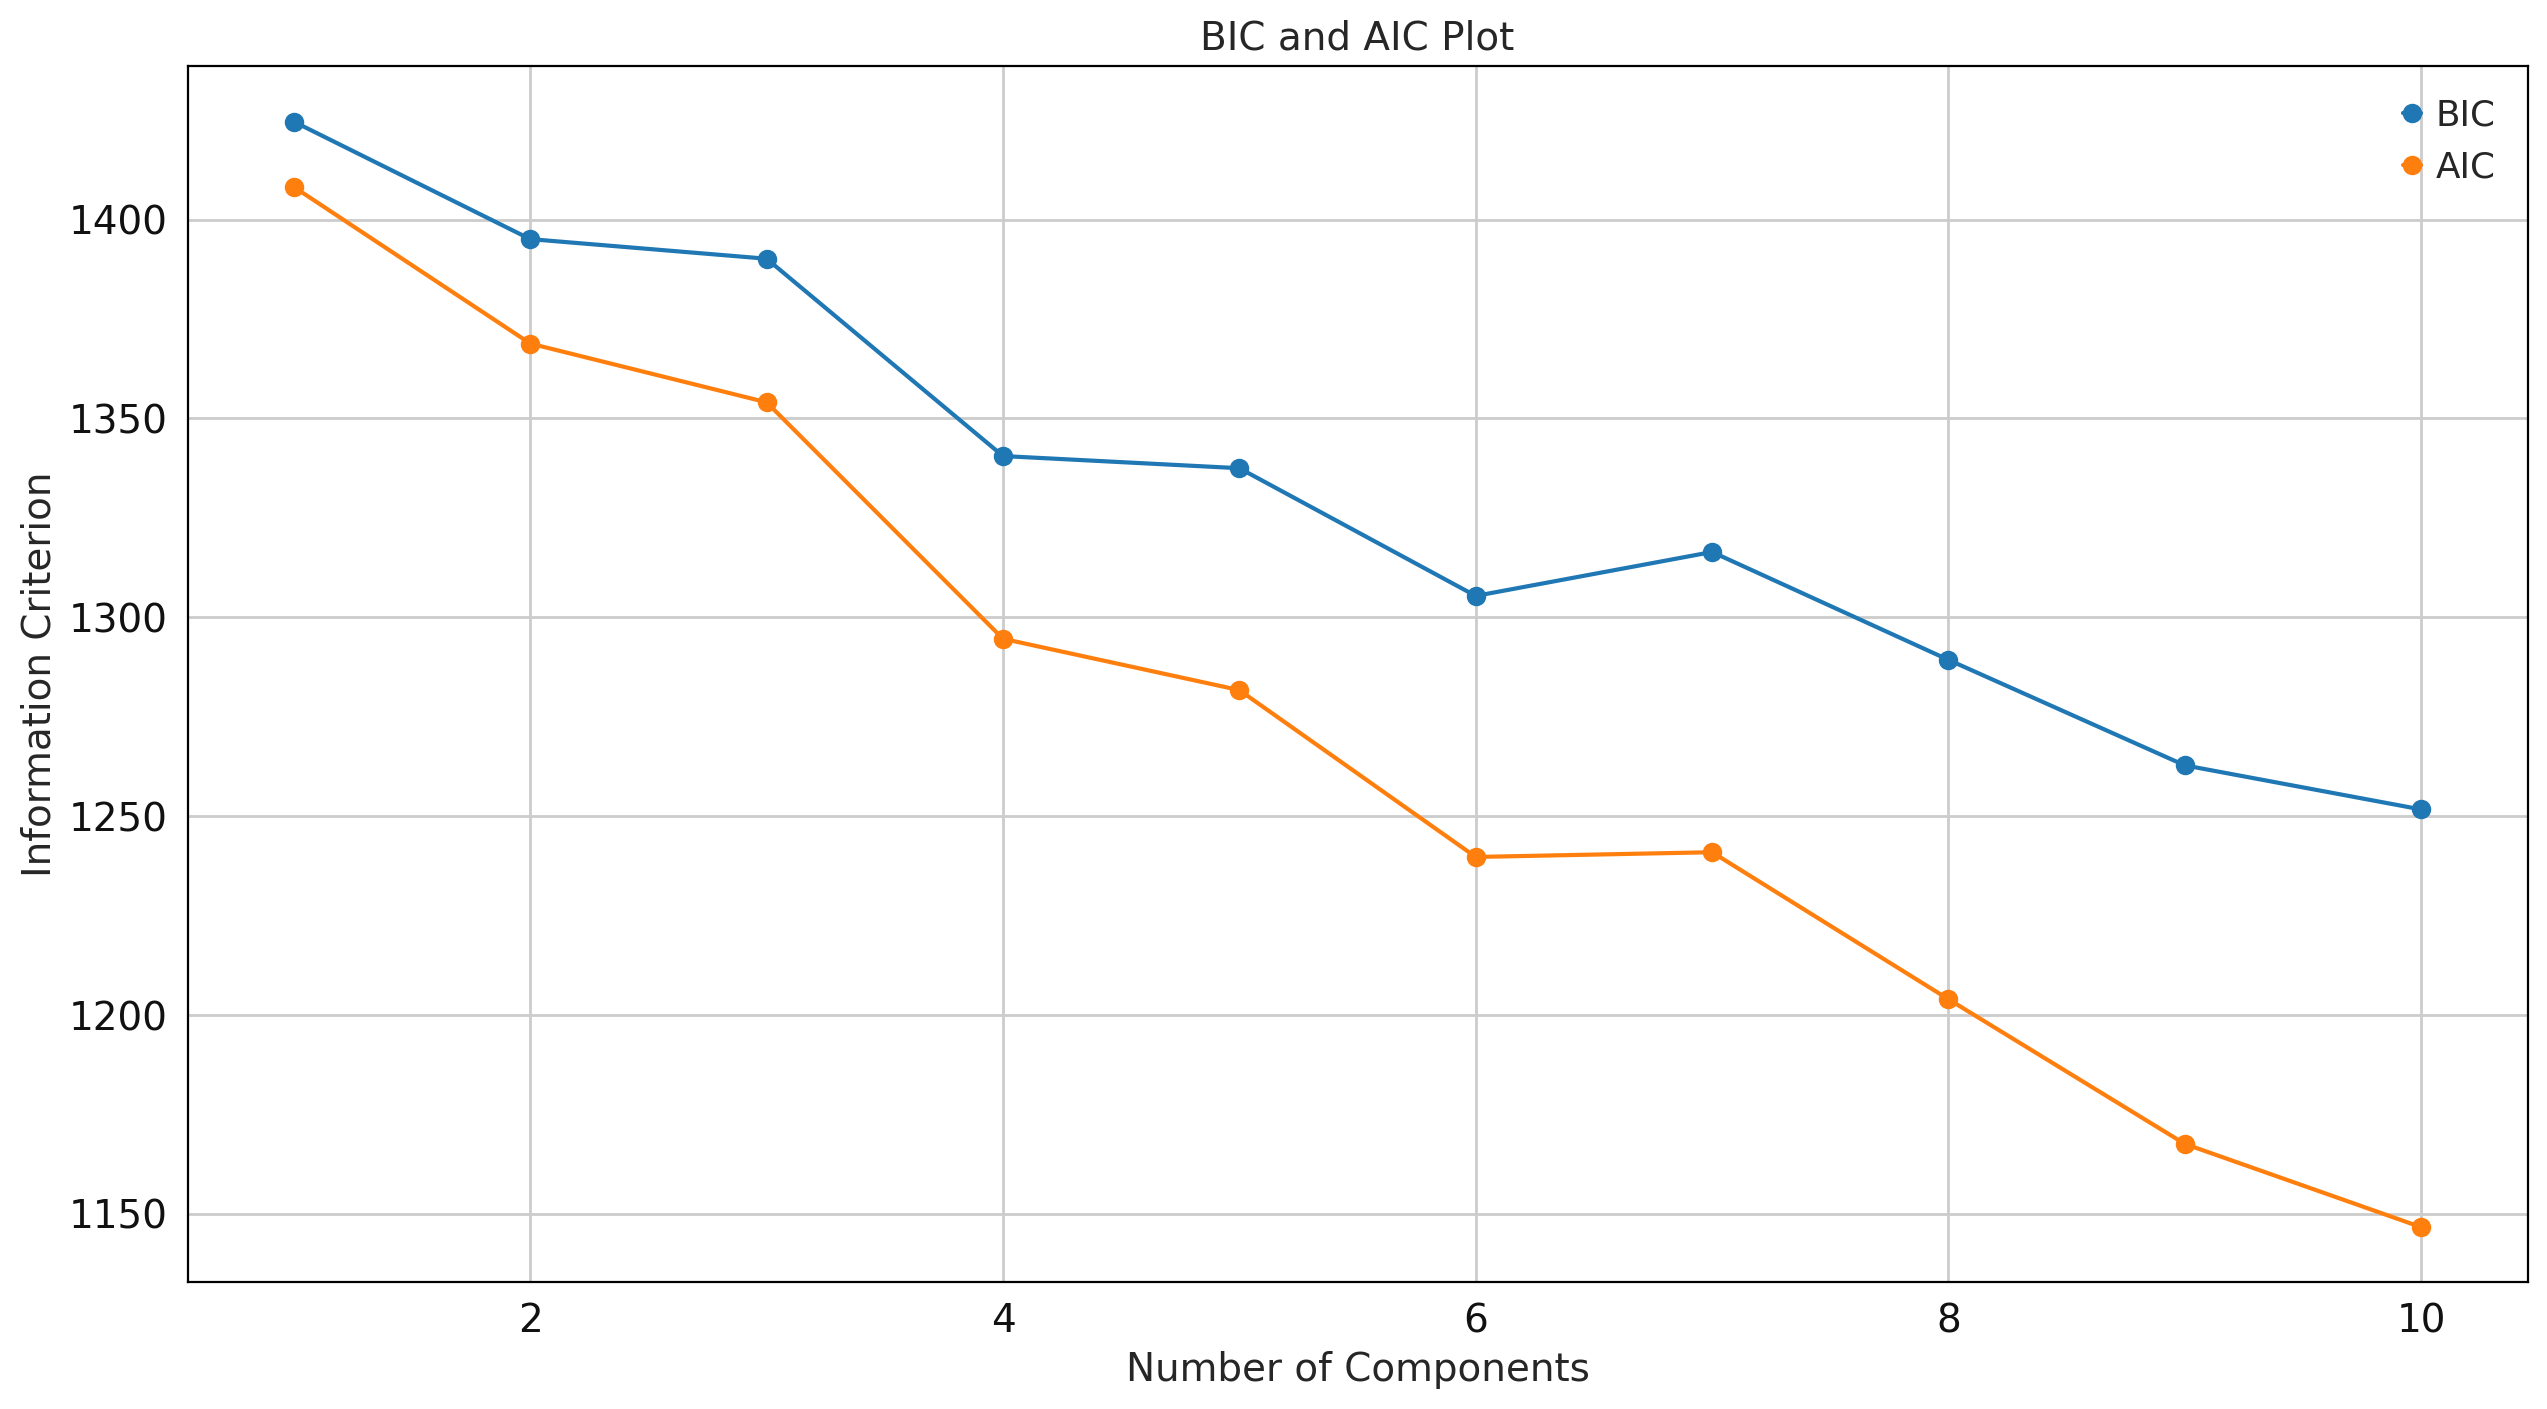

In [133]:
bic_plot(reduced_data_umap,10,results_df.covariance_type[1],results_df.n_init[1],results_df.reg_covar[1])

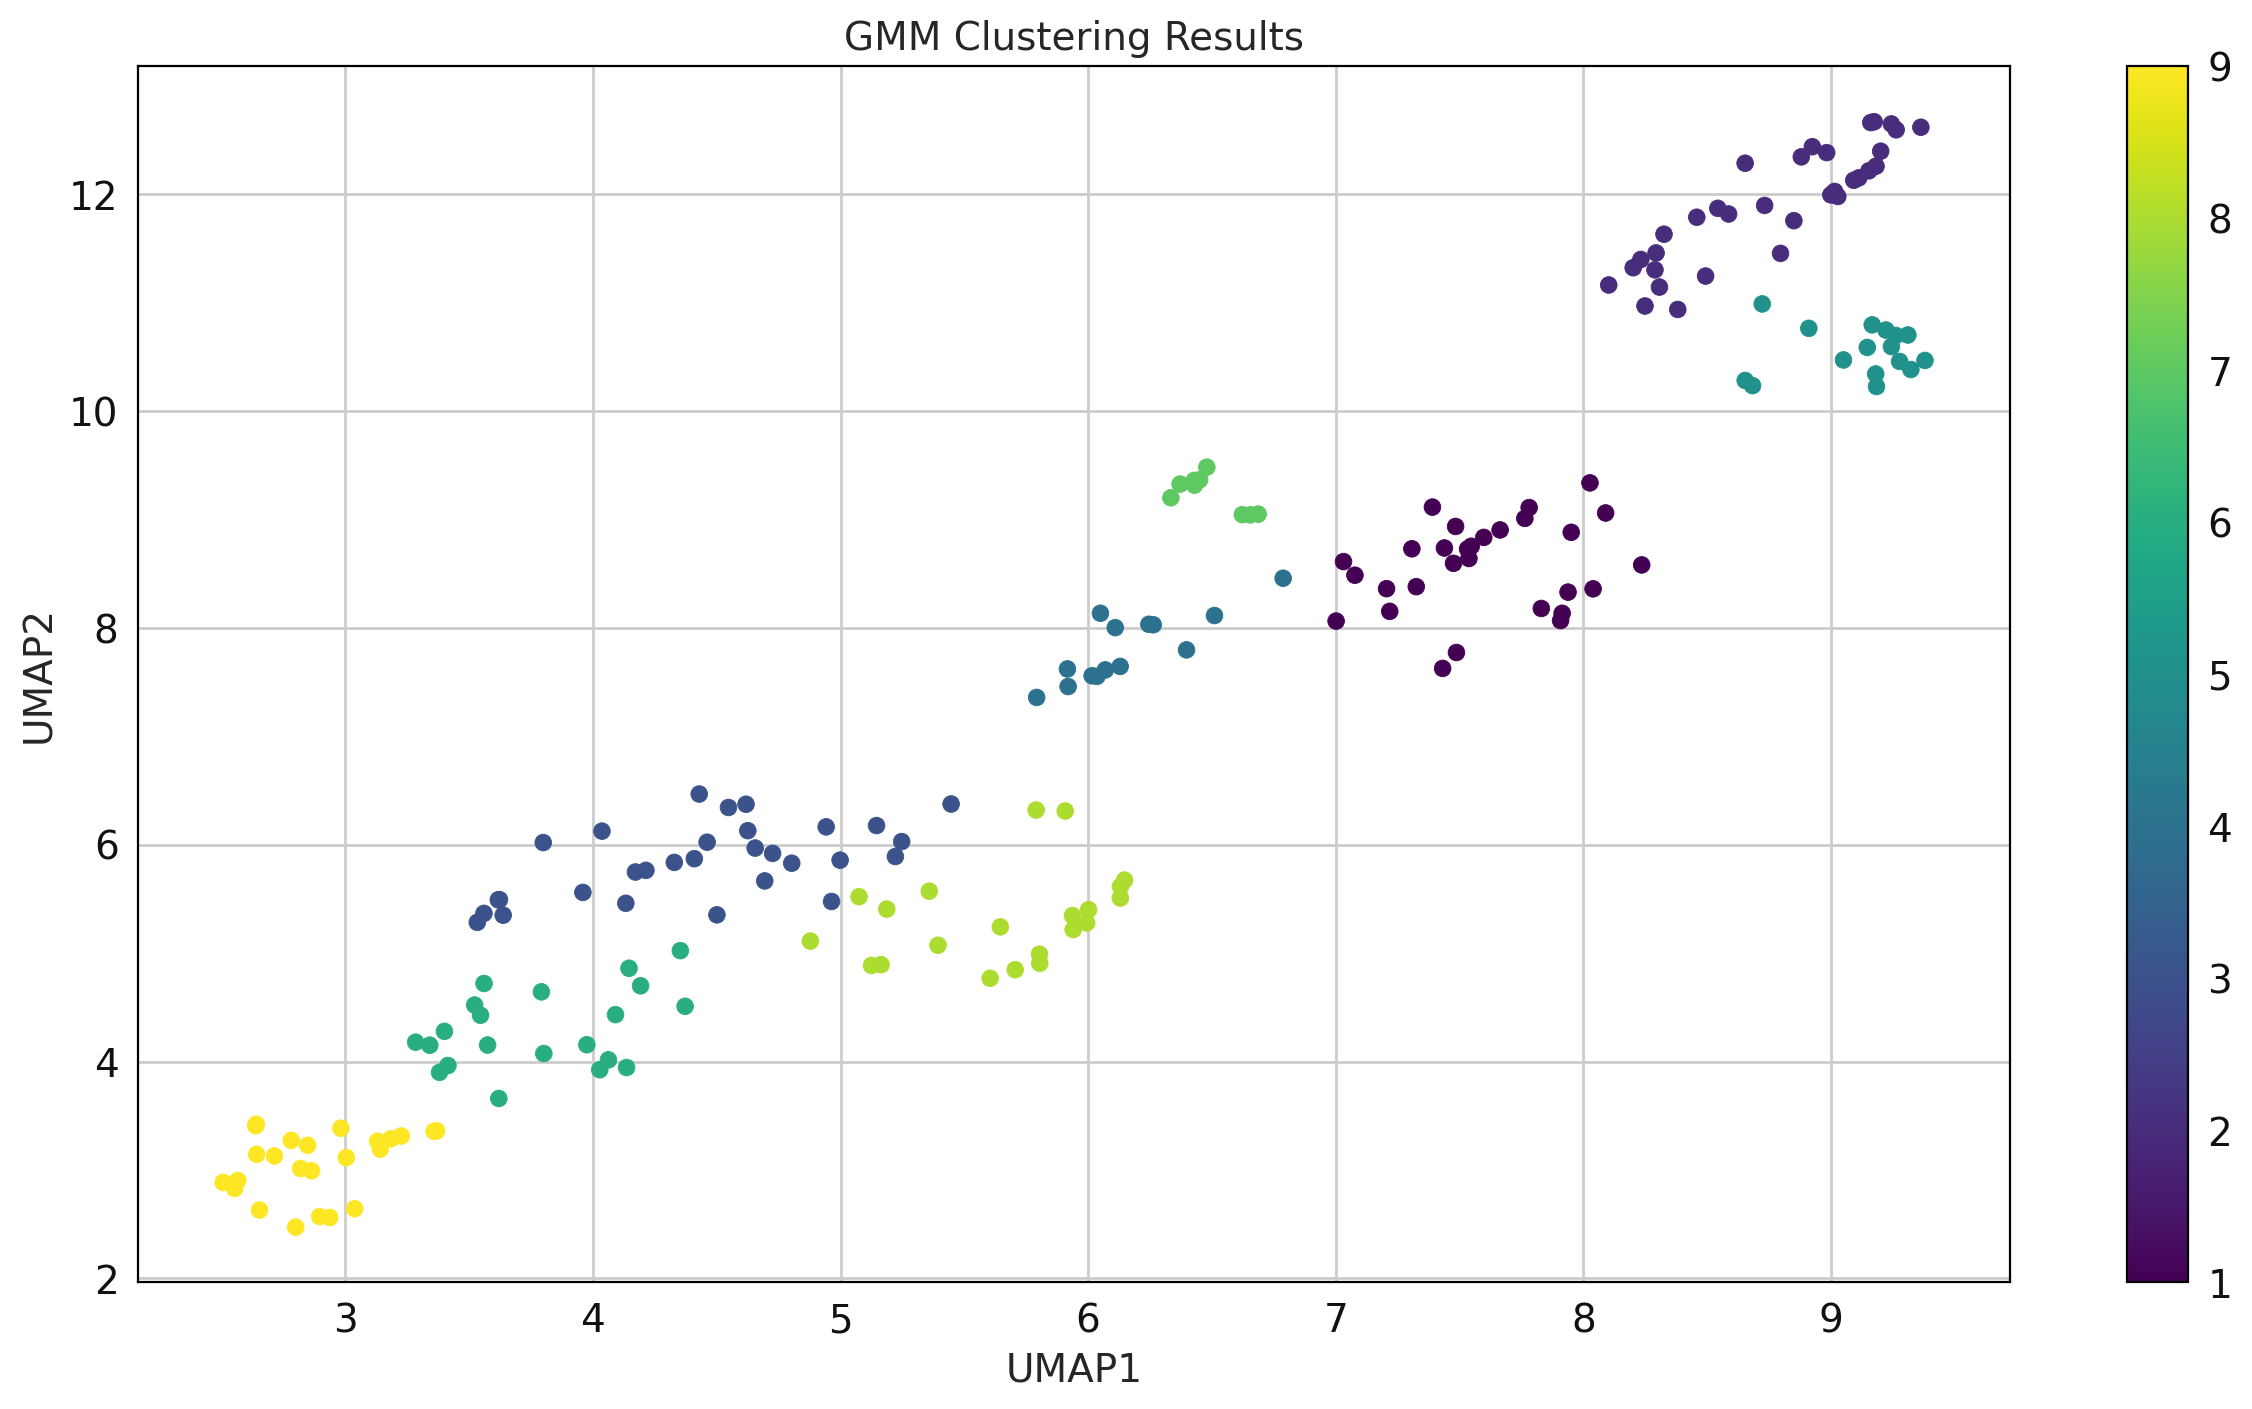

In [134]:
labels = gmm_optimal_umap.predict(reduced_data_umap)

plt.scatter(reduced_data_umap[:, 0], reduced_data_umap[:, 1], c=labels, cmap='viridis')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('GMM Clustering Results')
plt.colorbar()  

plt.show()

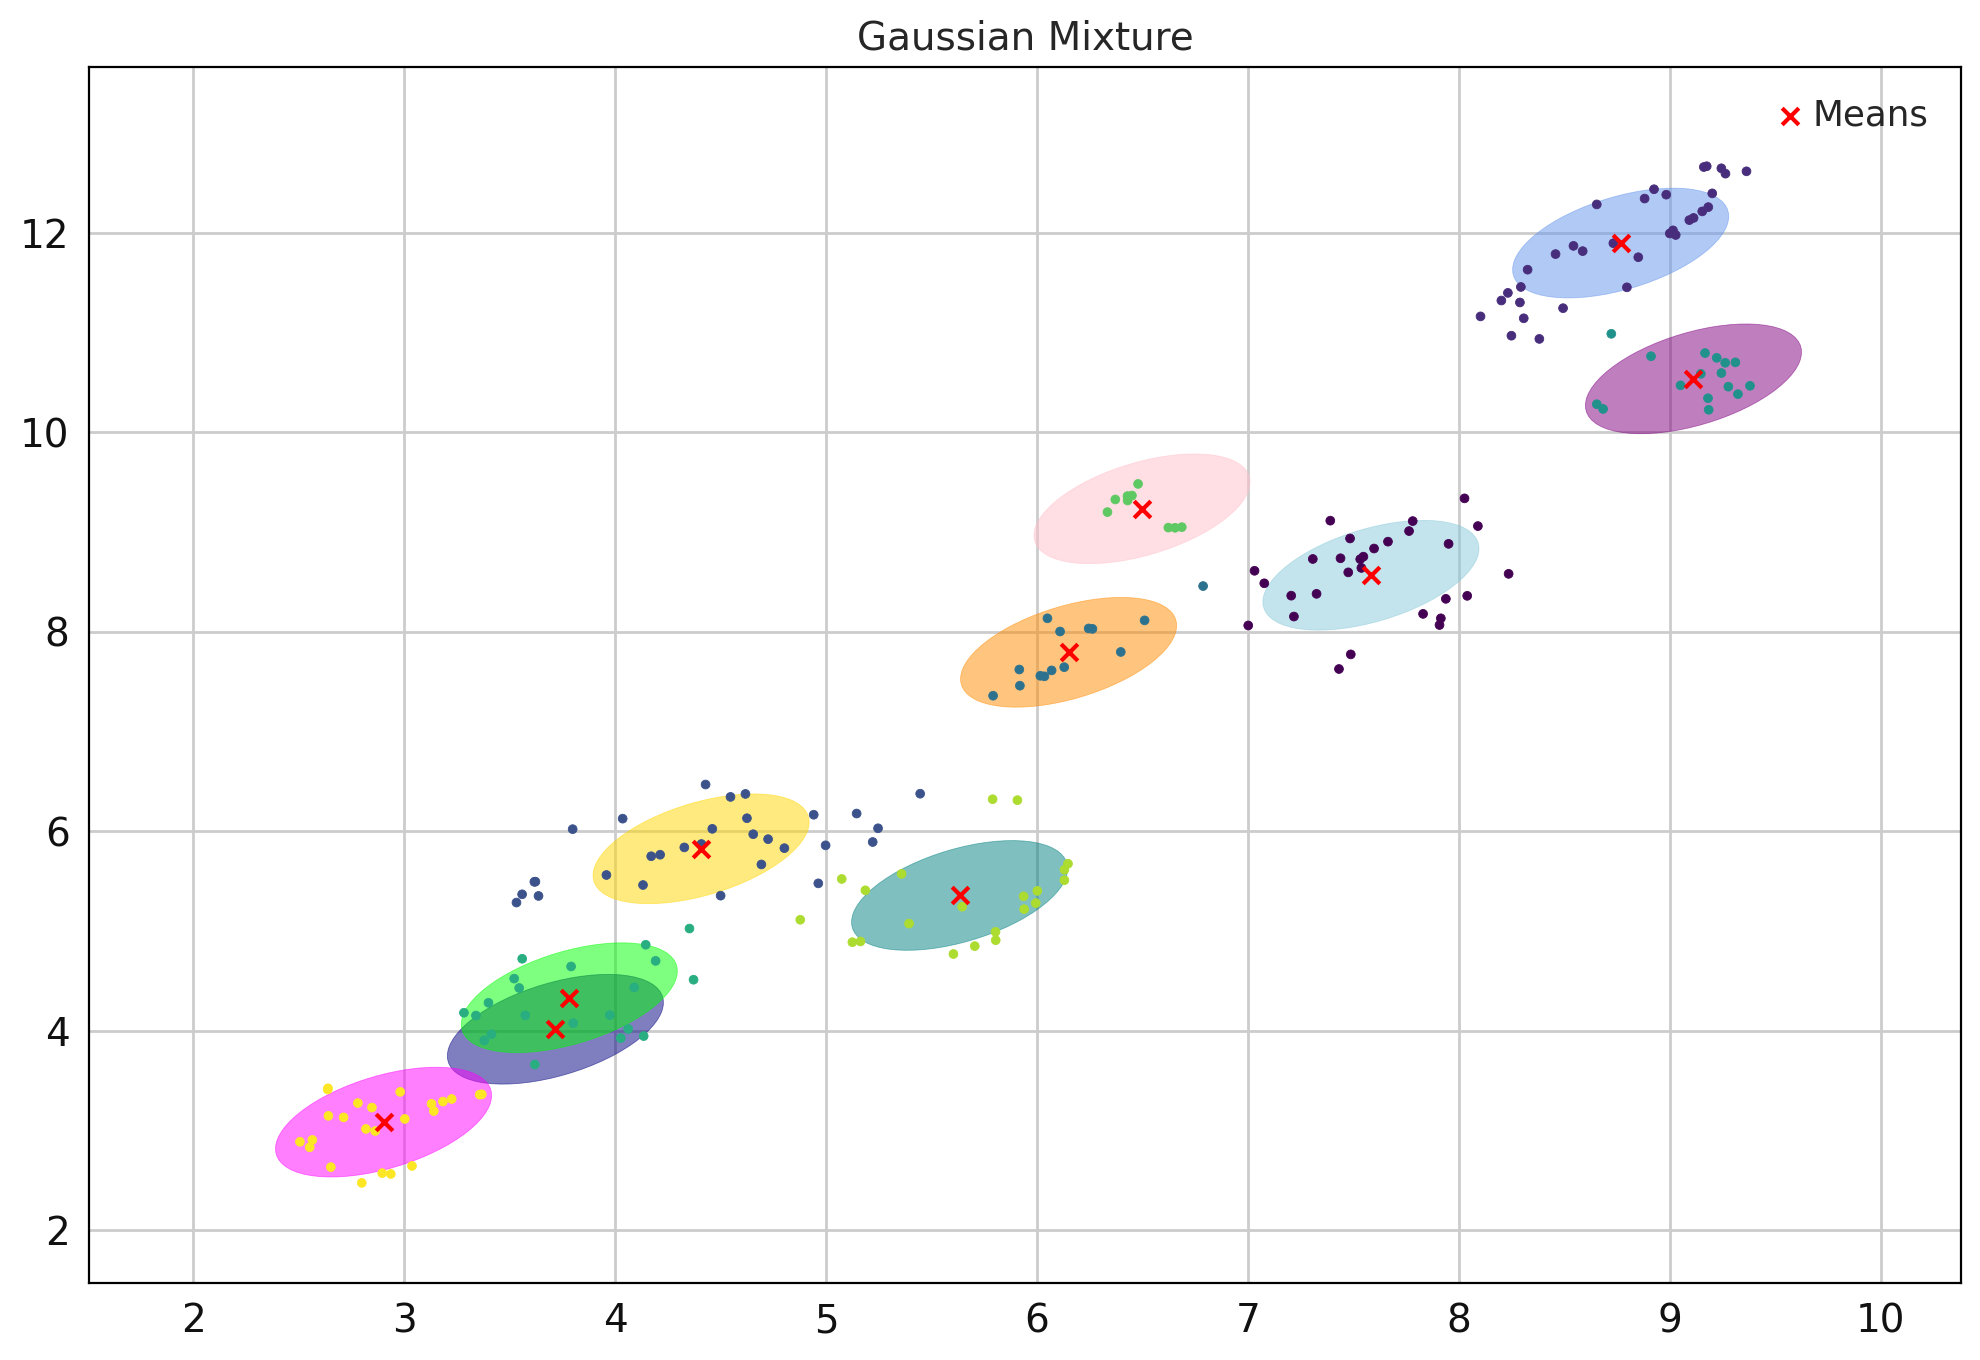

In [135]:
plot_results(gmm_optimal_umap,reduced_data_umap, "Gaussian Mixture")

## GMM for TSNE ##

In [136]:
reduced_data_tsne ,best_params_tsne, best_bic_score_tsne = find_best_gmm_parameters(adata_gmm, 'X_tsne',10)
print("Best Parameters:", best_params_tsne)
print("Best BIC Score:", best_bic_score_tsne)

Best Parameters: {'covariance_type': 'tied', 'n_components': 10, 'n_init': 10, 'reg_covar': 0.0001}
Best BIC Score: 3173.414380285343


In [137]:
gmm_optimal_tsne = GaussianMixture(**best_params_tsne)
gmm_optimal_tsne.fit(reduced_data_tsne)
posterior_probs = gmm_optimal_tsne.predict_proba(reduced_data_tsne)
covariances_tsne = gmm_optimal_tsne.covariances_

In [138]:
new_row = {
    'n_components': best_params_tsne['n_components'],
    'covariance_type': best_params_tsne['covariance_type'],
    'reg_covar': best_params_tsne['reg_covar'],
    'n_init': best_params_tsne['n_init'],
    'bic_score': best_bic_score_tsne,
    'covariances': covariances_tsne,
    'adata': [reduced_data_tsne],
    'gmm': gmm_optimal_tsne,
    'title': 'T-SNE'
}

results_df = results_df.append(new_row, ignore_index=True)
results_df

n_components covariance_type  reg_covar  n_init    bic_score  \
0             5       spherical     0.0010      10  7043.673104   
1            10            tied     0.0001       1  1238.943401   
2            10            tied     0.0001      10  3173.414380   

                                         covariances  \
0  [1.185734653997816, 1.0993027769087025, 2.1548...   
1  [[0.1311663420394823, 0.06852067839468957], [0...   
2  [[9.769359245333298, -1.2355269571243792], [-1...   

                                               adata  \
0  [[-0.32677814, 0.4197753, -1.0248446, 0.050844...   
1  [[[5.907584, 6.310953], [8.236012, 8.581317], ...   
2  [[[-14.534107, 6.6039605], [24.026516, 24.1414...   

                                                 gmm  title  
0  GaussianMixture(covariance_type='spherical', n...    PCA  
1  GaussianMixture(covariance_type='tied', n_comp...   UMAP  
2  GaussianMixture(covariance_type='tied', n_comp...  T-SNE

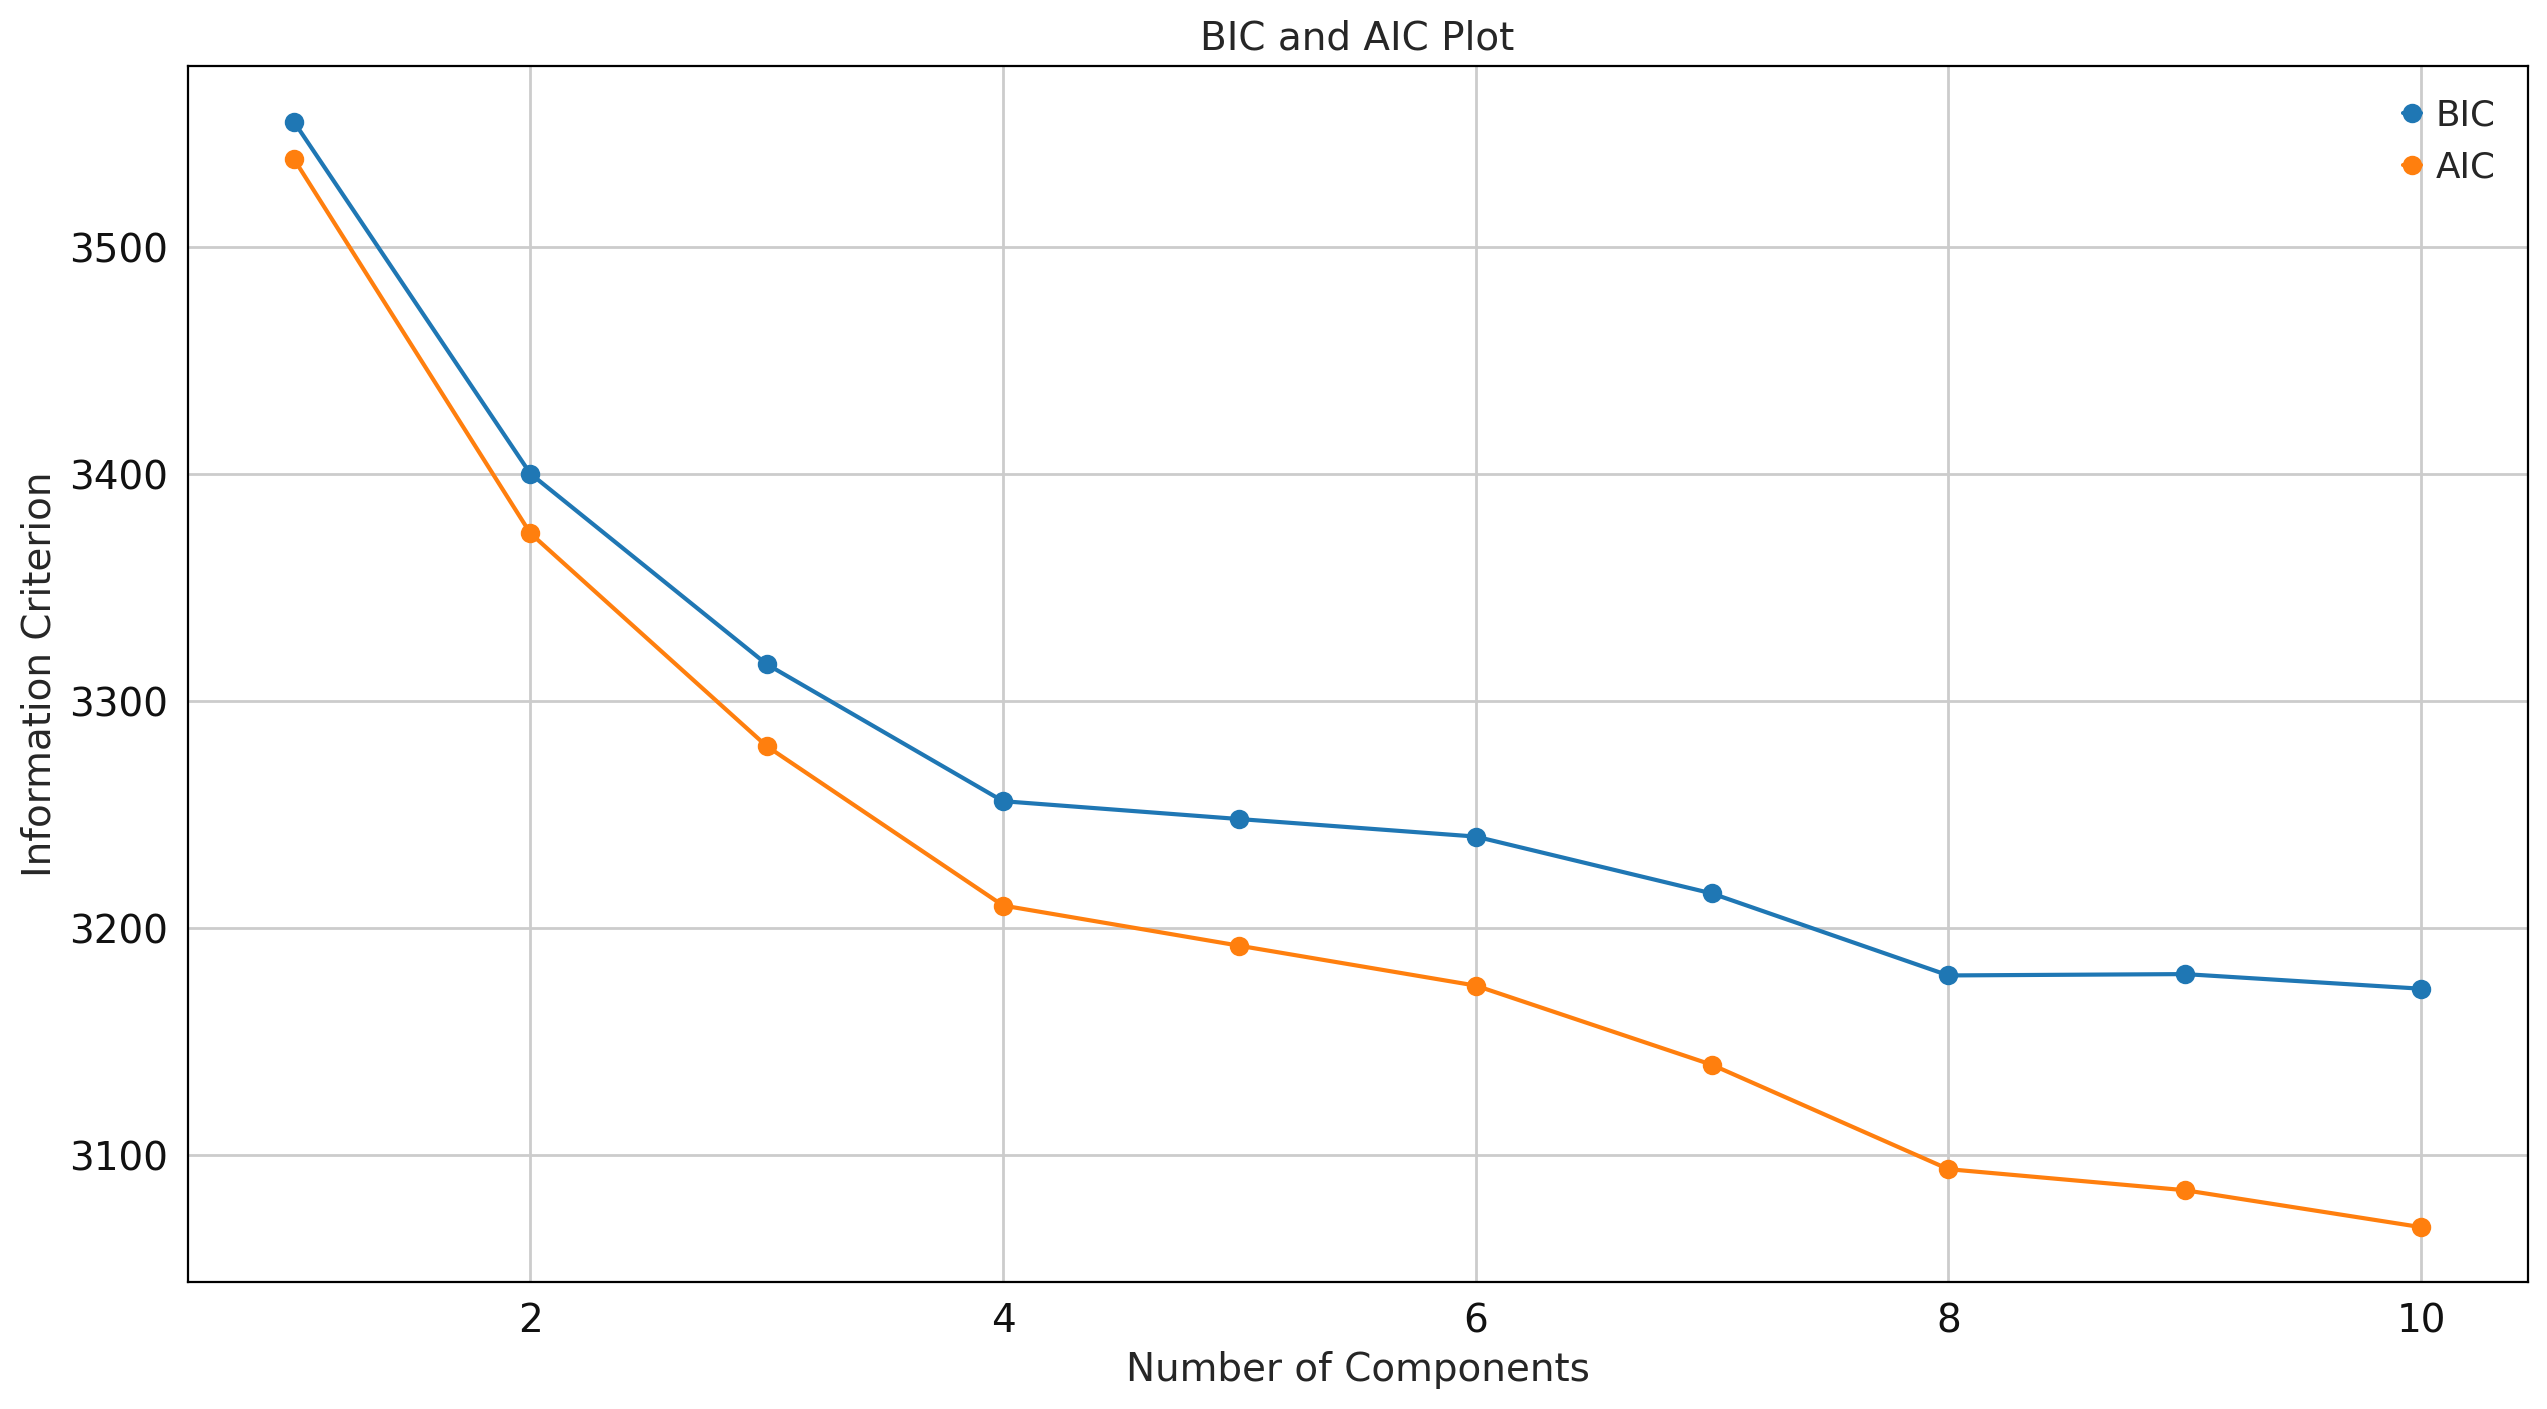

In [139]:
bic_plot(reduced_data_tsne,10,results_df.covariance_type[2],results_df.n_init[2],results_df.reg_covar[2])

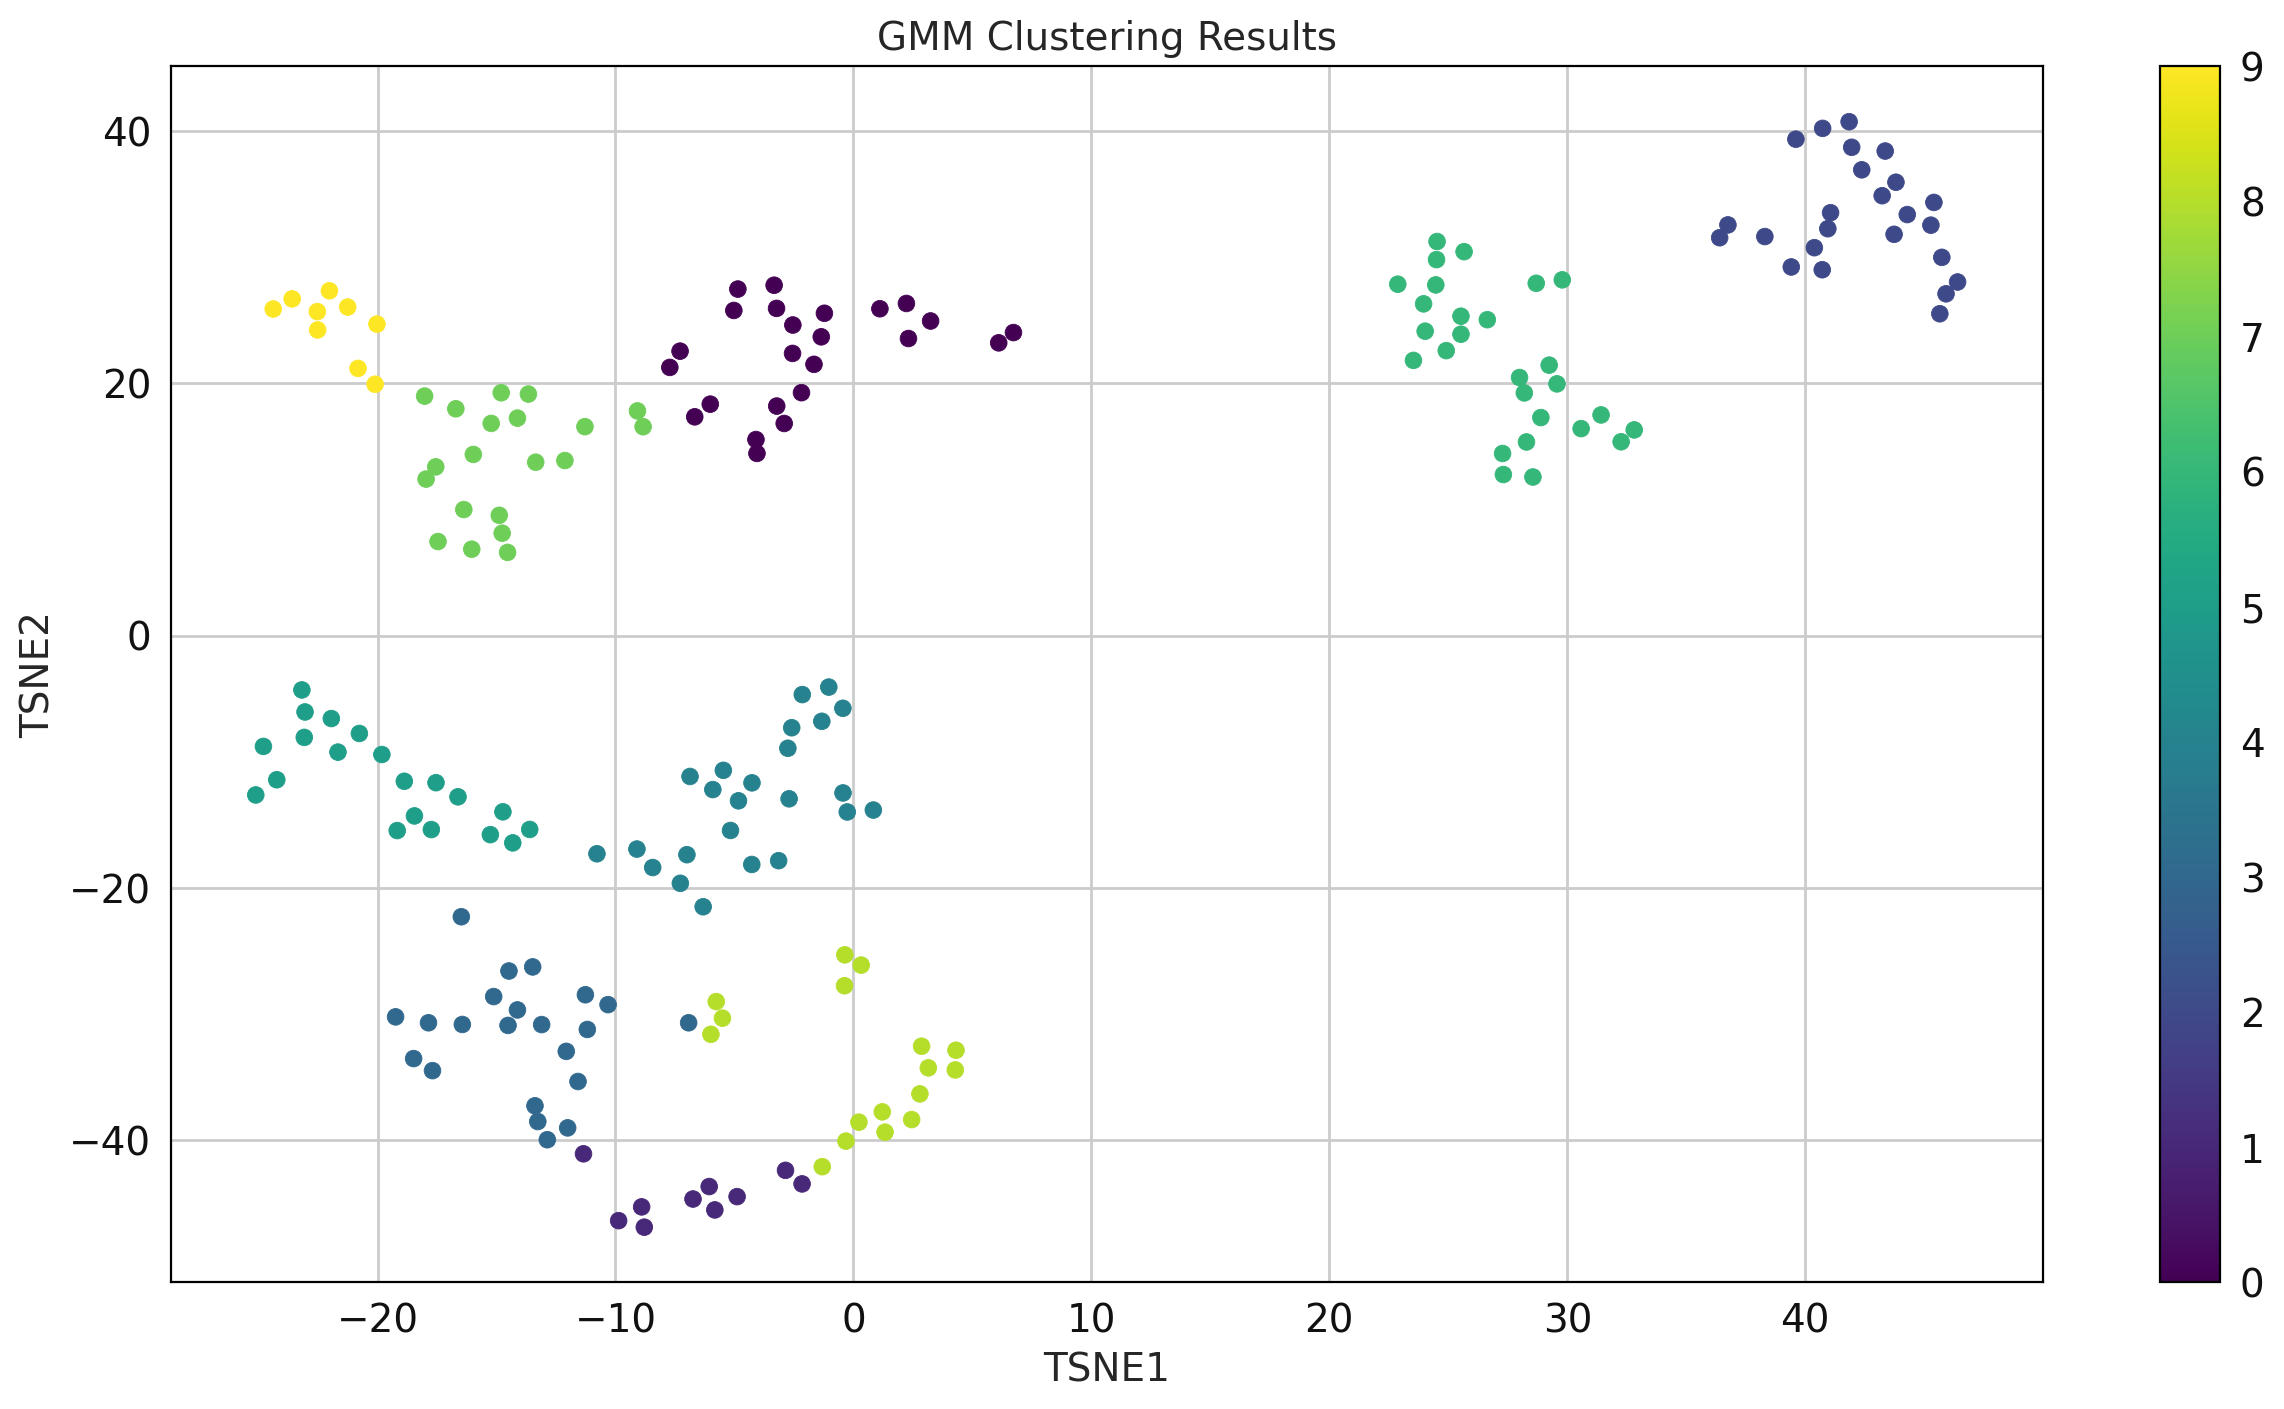

In [140]:
labels = gmm_optimal_tsne.predict(reduced_data_tsne)

plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=labels, cmap='viridis')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('GMM Clustering Results')
plt.colorbar()  

plt.show()

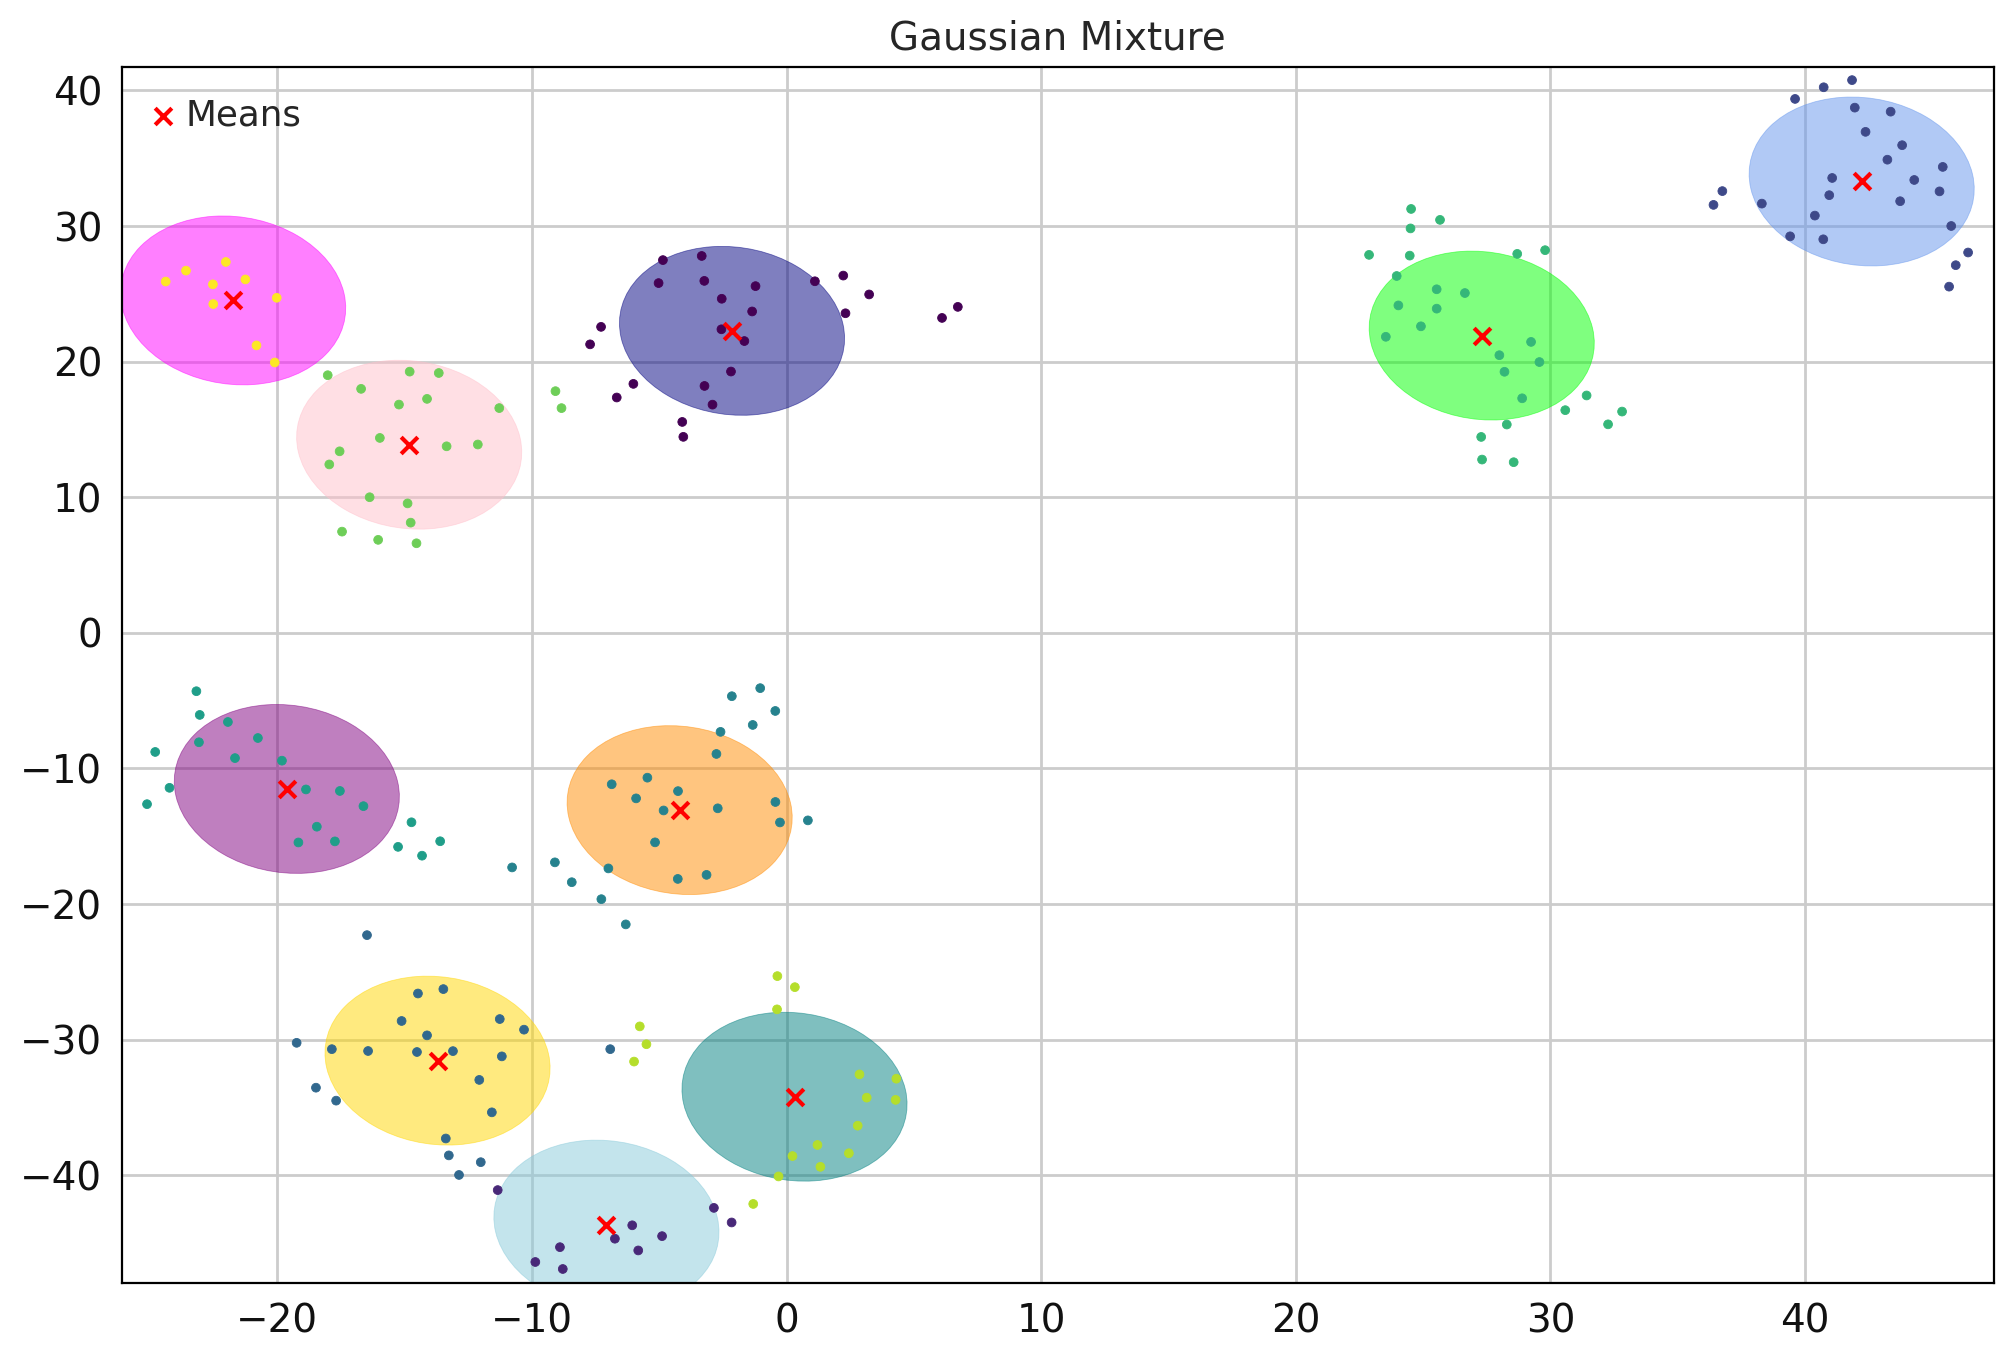

In [141]:
plot_results(gmm_optimal_tsne, reduced_data_tsne , "Gaussian Mixture")

# Visualization #

In [142]:
def posterior_viz(gmm, adata, title):
    posteriors = gmm.predict_proba(adata)
    component_labels = np.argmax(posteriors, axis=1)

    # Define colors for each component
    colors = ["navy", "c", "cornflowerblue", "gold", "darkorange", "purple", "lime", "pink", "teal", "yellow"]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Iterate over each component and assign colors based on the posterior probabilities
    legend_handles = []
    legend_labels = []
    for i, color in enumerate(colors):
        mask = component_labels == i
        if np.any(mask):  # Check if component has any data points
            scatter = ax.scatter(adata[mask, 0], adata[mask, 1], c=color, label=f'Component {i+1}')
            legend_handles.append(scatter)
            legend_labels.append(f'Component {i+1}')

    # Iterate over each point and assign mixed colors based on the non-zero posterior probabilities
    for j in range(len(adata)):
        point_probs = posteriors[j]
        non_zero_probs = point_probs[point_probs > 0]
        if len(non_zero_probs) > 1:
            mixed_color = [0, 0, 0]  # Initialize mixed color as black
            for prob, color in zip(non_zero_probs, colors):
                rgb = mpl.colors.to_rgb(color)
                mixed_color_rgb = [c * prob for c in rgb]
                mixed_color = [c1 + c2 for c1, c2 in zip(mixed_color, mixed_color_rgb)]
            ax.scatter(adata[j, 0], adata[j, 1], c=[mixed_color], label='Mixed')

    color_iter = itertools.cycle(colors)

    for n, color in enumerate(colors[:gmm.n_components]):
        mean = gmm.means_[n, :2]
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='black', marker='x', label='Means')
    
    # Calculate the joint probabilities for the grid points
    x = np.linspace(adata[:, 0].min() - 1, adata[:, 0].max() + 1, 100)
    y = np.linspace(adata[:, 1].min() - 1, adata[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_points = np.array([X_grid.ravel(), Y_grid.ravel()]).T
    joint_probs = np.exp(gmm.score_samples(grid_points))
    
    # Reshape the joint probabilities to match the grid shape
    Z = joint_probs.reshape(X_grid.shape)

    # Plot the contour lines of the joint probabilities

    # contour = ax.contourf(X_grid, Y_grid, Z, cmap='Blues', alpha=0.4)
    # ax.contour(X_grid, Y_grid, Z, levels=10, colors='k')
    # fig.colorbar(contour)
    
    ax.set_xlim([adata[:, 0].min() - 1, adata[:, 0].max() + 1])
    ax.set_ylim([adata[:, 1].min() - 1, adata[:, 1].max() + 1])        
    ax.set_title('Posterior Probabilities for ' + title)
    ax.legend(handles=legend_handles, labels=legend_labels)
    plt.show()


In [143]:
row_with_smallest_bic = results_df['bic_score'].idxmin()
smallest_bic_row = results_df.loc[row_with_smallest_bic]

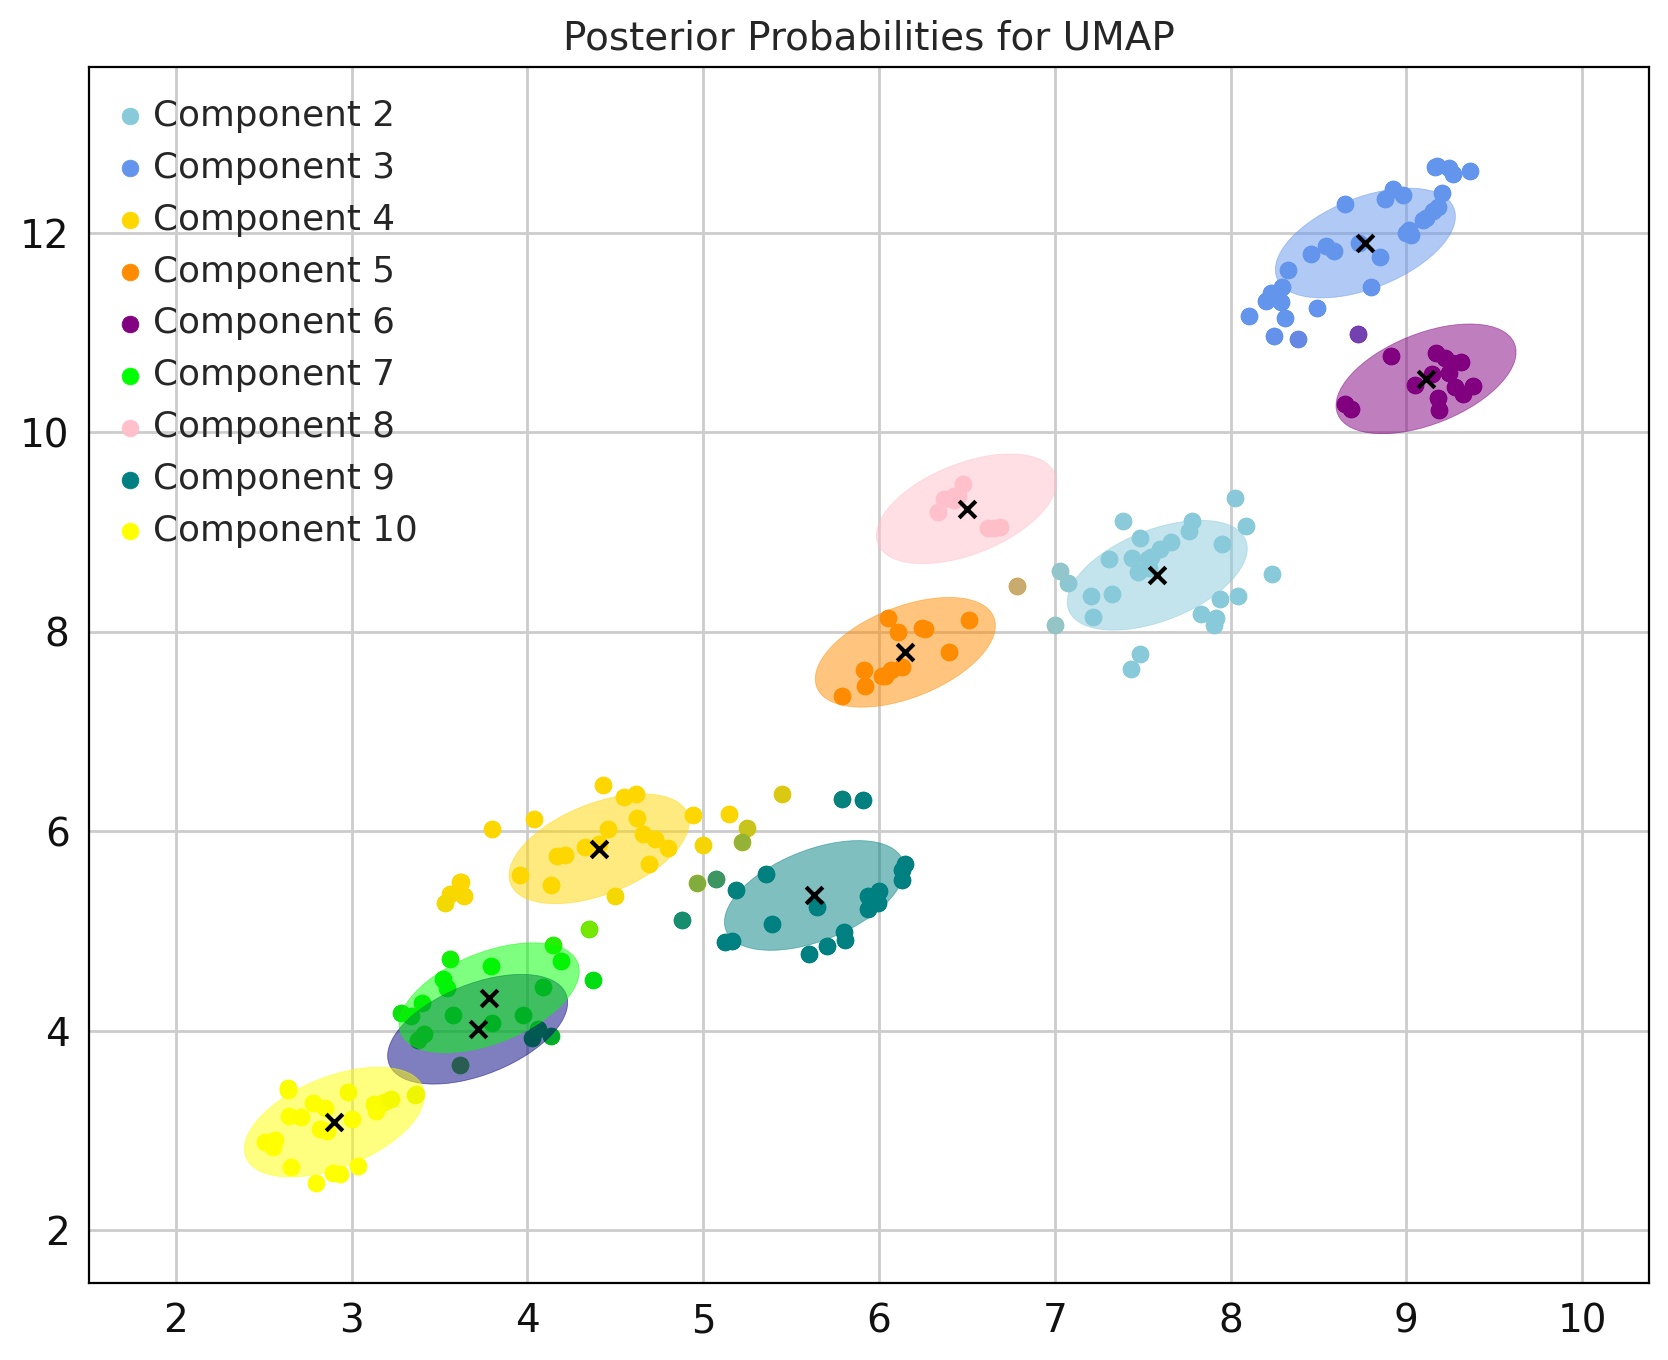

In [144]:
posterior_viz(smallest_bic_row.gmm, smallest_bic_row.adata[0], smallest_bic_row.title)

In [145]:
def posterior_viz_for_density(gmm, adata, title,elev, azim):
    x = np.linspace(adata[:, 0].min() - 1, adata[:, 0].max() + 1, 100)
    y = np.linspace(adata[:, 1].min() - 1, adata[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_points = np.array([X_grid.ravel(), Y_grid.ravel()]).T

    joint_probs = np.exp(gmm.score_samples(grid_points))
    Z = joint_probs.reshape(X_grid.shape)

    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contour(X_grid, Y_grid, Z, cmap='Blues')
    ax.clabel(contour, inline=True, fontsize=8)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_grid, Y_grid, Z, cmap='Blues')
    
    ax.set_xlabel(title+'1')
    ax.set_ylabel(title+'2')
    ax.set_title('Joint Probability Density for'+title)
    ax.view_init(elev=elev, azim=azim)
    
    plt.show()

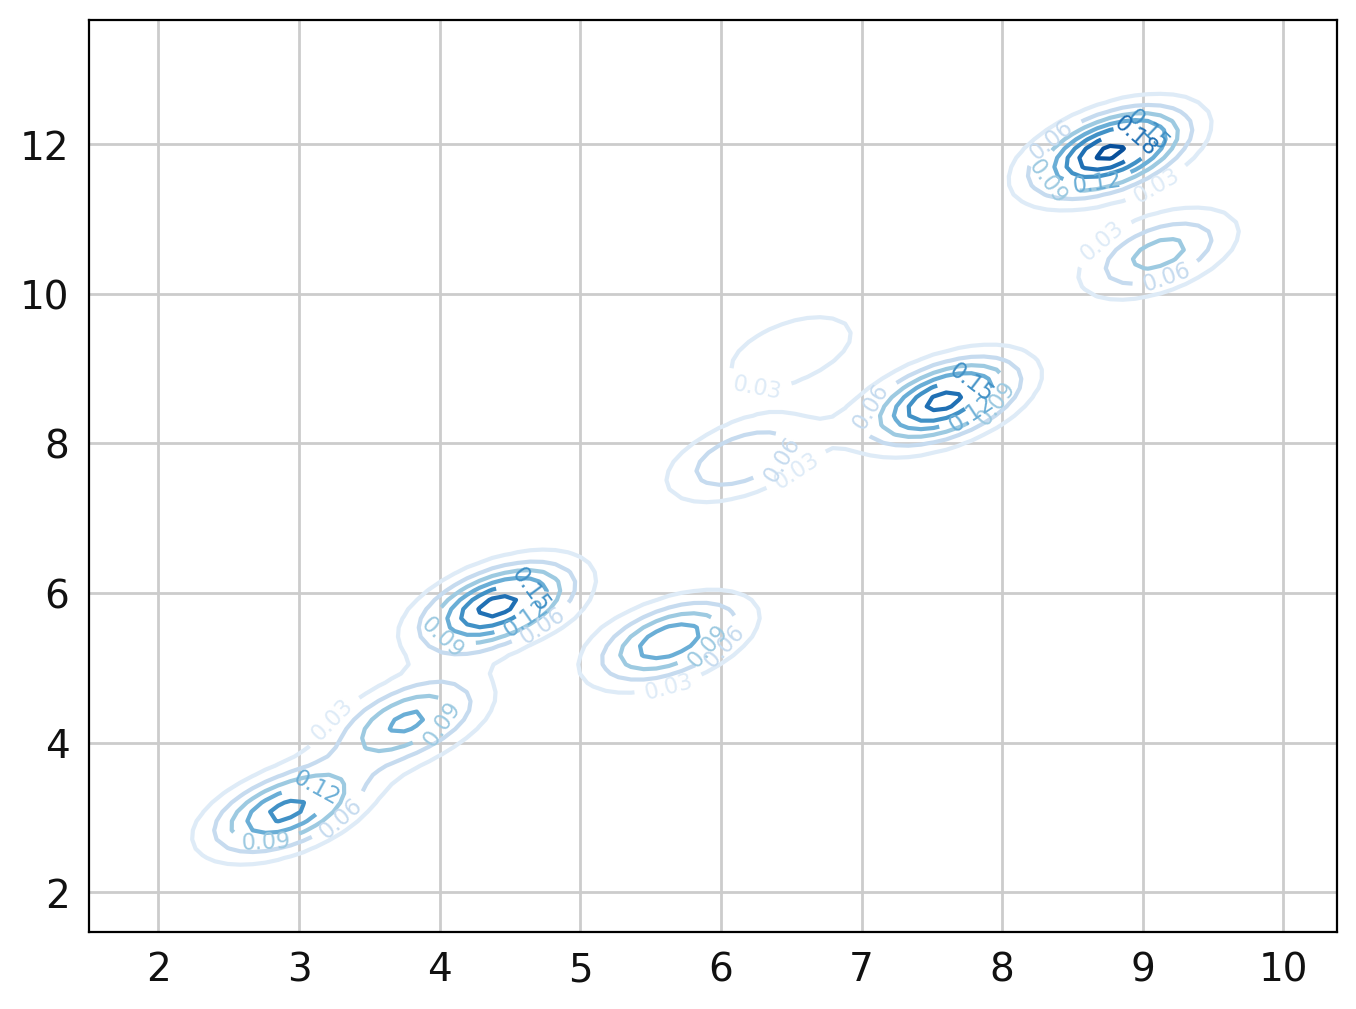

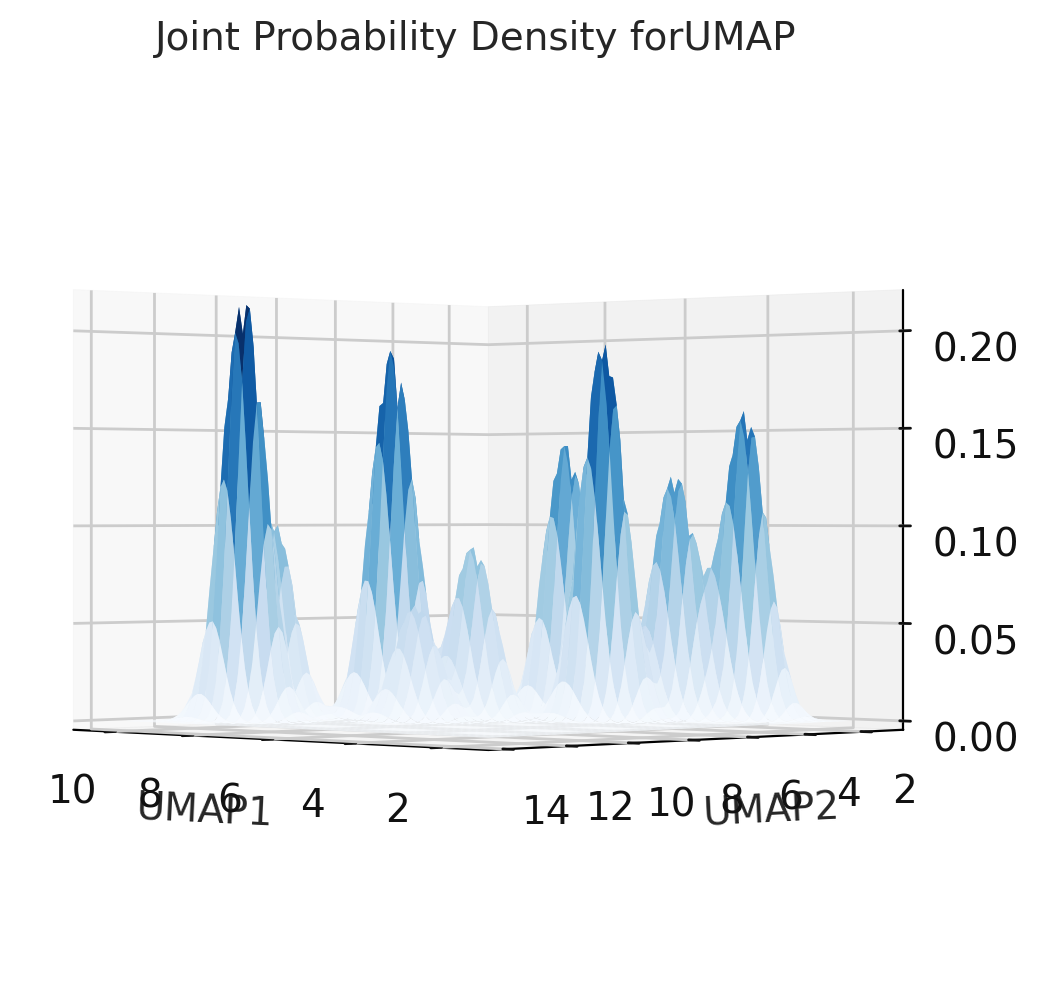

In [146]:
posterior_viz_for_density(smallest_bic_row.gmm, smallest_bic_row.adata[0], smallest_bic_row.title,0,135)